In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import metabolinks as mtl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import multianalysis as ma
import metabolinks.transformations as transf
import netlsd as nl
import itertools

# Formula Networks using Cytoscape Plugin MetaNetter

This notebook will cover the explorative studies into making networks from a list of masses. Each m/z will represent a node. Nodes will be connected if the difference in their masses can be due to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of the formula. It is somewhat similar to what was obtained with formulas assigned.


## 2 analysis of 2 networks (total 4):

### 1 - TF - Using the transformation list created here with the transformations mentioned and described in Formula_Networks

PS: I need better descriptions and justifications of them - total of 16

### 2 - MN - Using the transformation list default to the plugin MetaNetter but only considering most of the groups (until a max of 80 m/z).

- Only took out Arginine, Arg to Ornitine (aminoacid related) and pyrophosphate (PP).
- Left 30 different groups - almost double from our original list, more edges expected in the resulting networks.
- Most of our 16 transformation list is in this list with some exceptions (S, CHOH, OH (that I don't have a good justification to leave in) and NCH), some differences (different de-amination). One different group is noteworthy - carbamoylatransferase - where only one can be correct (CONH in our list versus CONH2 in theirs).

MetaNetter papers:

- MetaNetter - https://academic.oup.com/bioinformatics/article/24/1/143/205461 (2nd author is the 1st author of the original MDiNs paper)
- MetaNetter 2.0 - https://pubmed.ncbi.nlm.nih.gov/29030098/

### Reading the files to make the list of masses that will be used in Cytoscape to make the network (explained later)

#### Reading Grapevine datasets

In [2]:
aligned_all_pos = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_pos')
aligned_all_neg = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg')

In [3]:
chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078)} 

In [4]:
aligned_all_pos

label      CAN                      CS               LAB                      \
            14  15        16        29  30        31   8         9        10   
96.999045  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
97.031130  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
97.071640  NaN NaN       NaN       NaN NaN       NaN NaN  108081.0       NaN   
97.100765  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
97.177455  NaN NaN  104165.0  146957.0 NaN  166304.0 NaN       NaN  153067.0   
...         ..  ..       ...       ...  ..       ...  ..       ...       ...   
853.851470 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
863.742605 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
864.749430 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
885.372610 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
907.353940 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   

label             PN  ... ROT        RU                           SYL  \
                  23  ...  22        35        36        37        11   
96.999045        NaN  ... NaN       NaN       NaN       NaN  106869.0   
97.031130    98169.0  ... NaN       NaN       NaN       NaN       NaN   
97.071640        NaN  ... NaN       NaN       NaN       NaN       NaN   
97.100765   179818.0  ... NaN       NaN       NaN       NaN       NaN   
97.177455   275602.0  ... NaN  430984.0  382831.0  712734.0  171313.0   
...              ...  ...  ..       ...       ...       ...       ...   
853.851470  472207.0  ... NaN       NaN       NaN       NaN       NaN   
863.742605       NaN  ... NaN       NaN       NaN  161976.0       NaN   
864.749430       NaN  ... NaN       NaN       NaN       NaN       NaN   
885.372610  973025.0  ... NaN       NaN       NaN       NaN       NaN   
907.353940       NaN  ... NaN       NaN       NaN       NaN       NaN   

label                          TRI                      
                  12  13        32        33        34  
96.999045        NaN NaN       NaN  110856.0       NaN  
97.031130        NaN NaN       NaN       NaN       NaN  
97.071640   110127.0 NaN       NaN       NaN       NaN  
97.100765        NaN NaN       NaN       NaN       NaN  
97.177455   113533.0 NaN       NaN  198609.0  496041.0  
...              ...  ..       ...       ...       ...  
853.851470       NaN NaN       NaN       NaN       NaN  
863.742605       NaN NaN  268862.0       NaN  269364.0  
864.749430       NaN NaN  130892.0       NaN       NaN  
885.372610       NaN NaN       NaN       NaN       NaN  
907.353940       NaN NaN       NaN       NaN       NaN  

[7026 rows x 33 columns]

In [5]:
electron_mass = 0.000548579909065

In [6]:
new_index_pos = aligned_all_pos.index - chemdict['H'][0] + electron_mass
new_index_neg = aligned_all_neg.index + chemdict['H'][0] - electron_mass

In [7]:
aligned_all_pos.index = new_index_pos
aligned_all_neg.index = new_index_neg

In [8]:
aligned_all_pos

label      CAN                      CS               LAB                      \
            14  15        16        29  30        31   8         9        10   
95.991769  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
96.023854  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
96.064364  NaN NaN       NaN       NaN NaN       NaN NaN  108081.0       NaN   
96.093489  NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
96.170179  NaN NaN  104165.0  146957.0 NaN  166304.0 NaN       NaN  153067.0   
...         ..  ..       ...       ...  ..       ...  ..       ...       ...   
852.844194 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
862.735329 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
863.742154 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
884.365334 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   
906.346664 NaN NaN       NaN       NaN NaN       NaN NaN       NaN       NaN   

label             PN  ... ROT        RU                           SYL  \
                  23  ...  22        35        36        37        11   
95.991769        NaN  ... NaN       NaN       NaN       NaN  106869.0   
96.023854    98169.0  ... NaN       NaN       NaN       NaN       NaN   
96.064364        NaN  ... NaN       NaN       NaN       NaN       NaN   
96.093489   179818.0  ... NaN       NaN       NaN       NaN       NaN   
96.170179   275602.0  ... NaN  430984.0  382831.0  712734.0  171313.0   
...              ...  ...  ..       ...       ...       ...       ...   
852.844194  472207.0  ... NaN       NaN       NaN       NaN       NaN   
862.735329       NaN  ... NaN       NaN       NaN  161976.0       NaN   
863.742154       NaN  ... NaN       NaN       NaN       NaN       NaN   
884.365334  973025.0  ... NaN       NaN       NaN       NaN       NaN   
906.346664       NaN  ... NaN       NaN       NaN       NaN       NaN   

label                          TRI                      
                  12  13        32        33        34  
95.991769        NaN NaN       NaN  110856.0       NaN  
96.023854        NaN NaN       NaN       NaN       NaN  
96.064364   110127.0 NaN       NaN       NaN       NaN  
96.093489        NaN NaN       NaN       NaN       NaN  
96.170179   113533.0 NaN       NaN  198609.0  496041.0  
...              ...  ..       ...       ...       ...  
852.844194       NaN NaN       NaN       NaN       NaN  
862.735329       NaN NaN  268862.0       NaN  269364.0  
863.742154       NaN NaN  130892.0       NaN       NaN  
884.365334       NaN NaN       NaN       NaN       NaN  
906.346664       NaN NaN       NaN       NaN       NaN  

[7026 rows x 33 columns]

## Building the full network for the full Grapevine datasets in Cytoscape

To build the network in Cytoscape we'll need:

1) A list of masses (with masses as float in node attributes).

2) A list of allowed transformations with specific mass differences (that will be in one case ours and in the other case from the default MetaNetter list as explained).

The network built in Cytoscape had a 1 ppm error allowed for edge establishment. Discussions on the format the network built is done later. Also, only one full network (in each case is done) and then subgraphs of it will be used for every sample instead of building one for each sample (also explained later).

### Writing a .csv file with a list of masses that is able to be correctly read by Cytoscape's MetaNetter (and Cytoscape) where the network will be built

The list of masses in a .csv file. Two columns with the list of masses (one index, one in the column) for one to be the node name as a 'string' and the other node attribute as a 'float'.

In [9]:
pd.DataFrame(aligned_all_pos.index, index=aligned_all_pos.index).to_csv('MassList_PGD.csv')
pd.DataFrame(aligned_all_neg.index, index=aligned_all_neg.index).to_csv('MassList_NGD.csv')

### Making the transformation file

This file will be in a format accepted by Cytoscape's MetaNetter (.txt separated by tabs) to be considered as a list of transformations (with specific masses) to make the MDiN. 4 columns: 'Label','Formula','Mass','Selected' with mass being the most important.

Since Label is the 2nd most important since the existence of the transformation attribute of each edge (important for group_influence calculated), I'll put the formula changes in label and reactions that describe functions in formula.

In [10]:
#Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances - https://ciaaw.org/isotopic-abundances.htm / https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
#isotoptic abundances from Pure Appl. Chem. 2016; 88(3): 293–306, Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503
#electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078)} 

Functions to transform formulas in string format to dictionary format and from this to calculate formulas exact masses

In [11]:
def formula_process(formula):
    """Transforms a formula in string format into a dictionary."""
    
    #results = pd.DataFrame(np.zeros((1,8)), columns = ['C','H','O','N','S','P','Cl','F'])
    #Empty dictionary to store the results
    results = dict.fromkeys(['C','H','O','N','S','P','Cl','F'], 0)
    count = ''
    letter = None
    
    #Run through the string
    for i in range(len(formula)):
        if formula[i].isupper(): #If i is an uppercase letter then it is an element
            if letter: #Just to account for the first letter in the formula where letter is None
                results[letter] = int(count or 1) #Reached another letter, store previous results and reset count
                count = ''
                
            if i+1 < len(formula): #In case it's a two letter element such as Cl
                if formula[i+1].islower(): #The second letter is always lower case
                    letter = formula[i] + formula[i+1] #Store new 2 letter element
                    continue
                    
            letter = formula[i] #Store new 1 letter element
            
        elif formula[i].isdigit():
            count = count + formula[i] #If number, add number to count
    
    #Store results of the last letter
    results[letter] = int(count or 1)
                    
    return results

In [12]:
def getmass(c,h,o,n,s,p,cl,f):
    "Get the exact mass for any formula."
    massC = chemdict['C'][0] * c
    massH = chemdict['H'][0] * h
    massO = chemdict['O'][0] * o
    massN = chemdict['N'][0] * n
    massS = chemdict['S'][0] * s
    massP = chemdict['P'][0] * p
    massCl = chemdict['Cl'][0] * cl
    massF = chemdict['F'][0] * f 

    massTotal = massC + massH + massO + massN + massS + massP + massCl + massF

    return massTotal

Making the transformation file

In [13]:
#Prepare DataFrame
trans_groups = pd.DataFrame(columns=['Label','Formula','Mass','Selected'])
trans_groups = trans_groups.set_index('Label')

#Group Formula changes
groups = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
#Reactions responsible for their respective group changes
labels = ['Hydrogenation','Methylation','Carboxylation/Decarboxylation','Oxygenation','Hydroxymethylation',
          'Formidoylation','Deamination','S','Carbamoylation','Phosphorylation','Transamination',
          'Sulphation','Formylation','Acetylation','Condensation/Dehydration']

for i in range(len(groups)): #Passing through each transformation/group
    #Calculate the exact mass of the groups
    a = formula_process(groups[i])
    group_mass = getmass(a['C'],a['H'],a['O'],a['N'],a['S'],a['P'],a['Cl'],a['F'])
    
    #Groups with removed things have to be done manually
    if groups[i] == 'O(-NH)':
        #print(i)
        group_mass = getmass(a['C'],-1,a['O'],-1,a['S'],a['P'],a['Cl'],a['F'])
    elif groups[i] == 'NH3(-O)':
        group_mass = getmass(a['C'],a['H'],-1,a['N'],a['S'],a['P'],a['Cl'],a['F'])
        
    #Making the row for each transformation
    string = groups[i]
    trans_groups.loc[string] = (labels[i], group_mass, 'true')
#print(trans_groups)

trans_groups = trans_groups.sort_values(by='Mass')
trans_groups

,Formula,Mass,Selected
Label,,,
O(-NH),Deamination,0.984016,true
NH3(-O),Transamination,1.031634,true
H2,Hydrogenation,2.015650,true
CH2,Methylation,14.015650,true
O,Oxygenation,15.994915,true
H2O,Condensation/Dehydration,18.010565,true
NCH,Formidoylation,27.010899,true
CO,Formylation,27.994915,true
CHOH,Hydroxymethylation,29.002740,true


In [14]:
#Saving the df as a .txt file in the described format
#trans_groups.to_csv('transgroups.txt', header=False, sep='\t')

## Reading the network obtained from Cytoscape after MDiN built from MetaNetter

The network was obtained in graphml format that networkX module can read. The networks aren't however in an ideal state.

- Nodes have a standard 'number' ID instead of the mass which is fortunately stored as the attribute 'mass'. Other attributes stored are irrelevant. In NetTF, I accidently let it store many attributes based on different statistical analysis which shouldn't be present.
- Edges among the different attributes have a very useful one called 'Transformation' which stores which group of the list was used to establish the edge.
- Finally, the graph is directed despite only having one connection between any two nodes. Since reactions are bidireccional, they will be transformed to undirected graphs. Below it is shown that the number of edges remains the same between the directed and undirected graph and that.

Changes that will be made:

- Nodes will be identified by their masses.
- Formulas assignments of MetaboScape will be given to the nodes/masses that had formula assignments (later we will se if there is conflict and inconsistencies between them - not yet implemented).
- Intensities of the node in each sample will be given later to store for each specific subgraph.

### NegTF and PosTF - Networks made with our list of transformations

In [15]:
#Reading the network made
NegTF_dir = nx.read_graphml('Network_NGD.graphml')
NegTF = NegTF_dir.to_undirected()

PosTF_dir = nx.read_graphml('Network_PGD.graphml')
PosTF = PosTF_dir.to_undirected()

In [16]:
print(len(NegTF_dir.edges()),len(NegTF.edges()))
print(len(NegTF_dir.nodes()),len(NegTF.nodes()))
print(len(PosTF_dir.edges()),len(PosTF.edges()))
print(len(PosTF_dir.nodes()),len(PosTF.nodes()))

1005 1005
3629 3629
6597 6597
7026 7026


In [17]:
#Making dicts for the new names and new attribute of each node for the network
new_nodes = dict.fromkeys(NegTF.nodes(),0)

for i,j in nx.get_node_attributes(NegTF,'mass').items(): #i is old name, j is mass/new name
    #print(i,j)
    new_nodes[i] = j

#Setting the new attribute formula and relabeling nodes
NegTF = nx.relabel_nodes(NegTF, mapping=new_nodes)

In [18]:
#Making dicts for the new names and new attribute of each node for the network
new_nodes = dict.fromkeys(PosTF.nodes(),0)

for i,j in nx.get_node_attributes(PosTF,'mass').items(): #i is old name, j is mass/new name
    #print(i,j)
    new_nodes[i] = j

#Setting the new attribute formula and relabeling nodes
PosTF = nx.relabel_nodes(PosTF, mapping=new_nodes)

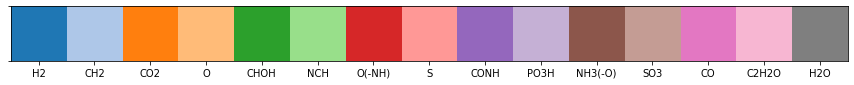

In [19]:
colours = sns.color_palette('tab20', 15)

unique_group = ['H2','CH2','CO2','O','CHOH','NCH','O(-NH)','S','CONH','PO3H','NH3(-O)','SO3','CO', 'C2H2O', 'H2O']
group_colors = {lbl: c for lbl, c in zip(unique_group, colours)}

sns.palplot(group_colors.values())
new_ticks = plt.xticks(range(len(unique_group)), unique_group)

edge_colors =  [group_colors[lbl] for lbl in nx.get_edge_attributes(NegTF,'Transformation').values()]

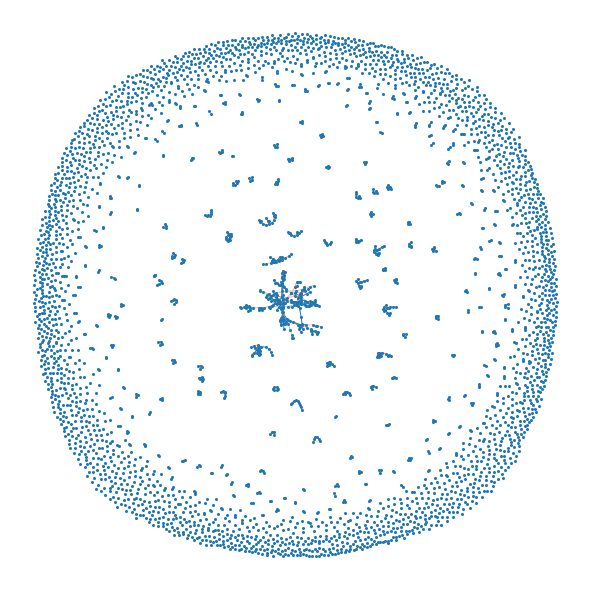

In [20]:
#Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(NegTF, node_size=4, width = 1, edge_color=edge_colors)
plt.show()

In [21]:
[len(c) for c in sorted(nx.connected_components(NegTF), key=len, reverse=True)][:20]

[183, 21, 21, 18, 15, 13, 12, 12, 12, 11, 9, 9, 9, 7, 7, 7, 6, 6, 6, 6]

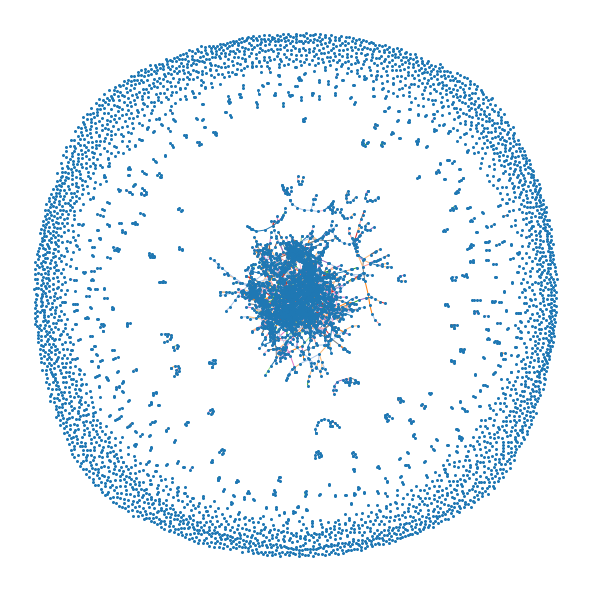

In [22]:
edge_colors =  [group_colors[lbl] for lbl in nx.get_edge_attributes(PosTF,'Transformation').values()]
#Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(PosTF, node_size=4, width = 1, edge_color=edge_colors)
plt.show()

In [23]:
[len(c) for c in sorted(nx.connected_components(PosTF), key=len, reverse=True)][:20]

[2482, 49, 40, 26, 19, 18, 17, 17, 16, 16, 13, 11, 11, 11, 10, 9, 9, 9, 9, 9]

#### Full Negative Grapevine Dataset Network Analysis with out transformation list (analysis that will be done for each individual sample network)

Group Influence calculation (H2, CH2, O, CO and H20 with a high group influences)

In [24]:
#Group Influence in building the network
NegTF_groups = dict.fromkeys(unique_group, 0) #groups from the transformation list
for i in NegTF.edges():
    NegTF_groups[NegTF.edges()[i]['Transformation']] = NegTF_groups[NegTF.edges()[i]['Transformation']] + 1

NegTF_groups

{'H2': 138,
 'CH2': 173,
 'CO2': 61,
 'O': 135,
 'CHOH': 36,
 'NCH': 34,
 'O(-NH)': 50,
 'S': 8,
 'CONH': 24,
 'PO3H': 9,
 'NH3(-O)': 120,
 'SO3': 9,
 'CO': 111,
 'C2H2O': 39,
 'H2O': 58}

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality.

In [25]:
#nx.degree(Gr)
NegTF_degree = dict(NegTF.degree())
NegTF_degree_all = sorted(NegTF_degree.items(), key=lambda kv: kv[1], reverse = True)
NegTF_degree_all[:10]

[(344.1113464522909, 10),
 (344.1109764522909, 8),
 (282.2565264522909, 8),
 (374.1584564522909, 7),
 (342.0957614522909, 7),
 (299.2546264522909, 7),
 (298.2512464522909, 7),
 (270.2202564522909, 7),
 (597.279296452291, 6),
 (356.1113364522909, 6)]

In [26]:
NegTF_betw = nx.betweenness_centrality(NegTF)
NegTF_betw_all = sorted(NegTF_betw.items(), key=lambda kv: kv[1], reverse = True)
NegTF_betw_all[:10]

[(342.1323964522909, 0.0012777925949737376),
 (312.17625645229094, 0.0012522460329836649),
 (344.1482664522909, 0.0012509541175472817),
 (326.1917864522909, 0.001244646530416705),
 (340.2076214522909, 0.0012406187940562162),
 (370.1271264522909, 0.001219370514287544),
 (308.2358864522909, 0.0012078649379926186),
 (280.2408914522909, 0.0011938396447768),
 (372.1427964522909, 0.0007650925867663072),
 (282.2565264522909, 0.0007586580025760454)]

In [27]:
NegTF_closeness = nx.closeness_centrality(NegTF)
NegTF_closeness_all = sorted(NegTF_closeness.items(), key=lambda kv: kv[1], reverse = True)
NegTF_closeness_all[:10]

[(342.1323964522909, 0.007006983291039845),
 (370.1271264522909, 0.006953617081664066),
 (344.1482664522909, 0.006921985768176587),
 (312.17625645229094, 0.006813506886735012),
 (326.1917864522909, 0.006688717383314958),
 (356.1113364522909, 0.006592129406660591),
 (340.2076214522909, 0.006549569030290471),
 (300.12162145229087, 0.0065401856935708574),
 (326.1377564522909, 0.0065214994487320845),
 (356.11173145229094, 0.006516844559760826)]

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets)

In [28]:
def calculating_orbits(GG):
    """Calculates the number of times each node of the netwrok is in each possible (non-redundant) orbit in graphlets (maximum
    4 nodes).
    
    Function is not very efficient, all nodes are passed, every graphlet is 'made' for each node present in it so it is made
    multiple times. Maybe should put more comments throughout the function
    
       GG: networkx graph;
    
       returns: dict; dictionary (keys are the nodes) of dictionaries (keys are the orbits and values are the number of times)
    """
    
    node_orbits = {} #To store results

    for i in GG.nodes():

        node_orbits[i] = {} #To store results
        orbits = node_orbits[i]

        ##size of comp
        #comp = len(nx.node_connected_component(GG, 'c'))

        #2 node graphlets - orbit 0
        orbits['0'] = GG.degree(i)

        #3 node graphlets - orbit 1,2 (and 3 redundant)
        node_neigh = list(GG.neighbors(i))

        #orbit 1 and 4 and 6 and 8 and 9
        n_orb = 0
        n_orb4 = 0
        n_orb6 = 0
        n_orb8 = 0
        n_orb9 = 0

        #orbit 1
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for common in nx.common_neighbors(GG, i, j):
                neigh_neigh.remove(common)
            n_orb = n_orb + len(neigh_neigh)


            #orbit 4 and 8
            for n3 in neigh_neigh:
                neigh_neigh_neigh = list(GG.neighbors(n3))
                #neigh_neigh_neigh.remove(j)
                #if i in neigh_neigh_neigh:
                    #neigh_neigh_neigh.remove(i)     
                for common in nx.common_neighbors(GG, j, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)

                for common in nx.common_neighbors(GG, i, n3):
                    if common in neigh_neigh_neigh:
                        neigh_neigh_neigh.remove(common)
                        #orbit 8
                        if common != j:
                            #print(i,j,n3,common)
                            n_orb8 = n_orb8 + 1/2 #always goes in 2 directions so it will always pass like this

                n_orb4 = n_orb4 + len(neigh_neigh_neigh)
                #print(neigh_neigh_neigh)

            #orbit 6 and 9
            for u,v in itertools.combinations(neigh_neigh, 2):
                if not GG.has_edge(u,v):
                    n_orb6 = n_orb6 + 1
                else:
                    n_orb9 = n_orb9 + 1         

        orbits['1'] = n_orb

        #orbit 2 and 5
        n_orb = 0
        n_orb5 = 0
        for u,v in itertools.combinations(node_neigh, 2):
            if not GG.has_edge(u,v):
                n_orb = n_orb + 1

                #orbit 5
                neigh_u = list(GG.neighbors(u))
                neigh_u.remove(i)
                for common in nx.common_neighbors(GG, i, u):
                    neigh_u.remove(common)

                neigh_v = list(GG.neighbors(v))
                neigh_v.remove(i)
                for common in nx.common_neighbors(GG, i, v):
                    neigh_v.remove(common)

                for common in nx.common_neighbors(GG, v, u):
                    if common in neigh_u:
                        neigh_u.remove(common)
                    if common in neigh_v:
                        neigh_v.remove(common) 

                n_orb5 = n_orb5 + len(neigh_u)
                n_orb5 = n_orb5 + len(neigh_v)

        orbits['2'] = n_orb

        #4 node graphlets - orbit 4,5,6,7,8,9,10,11 (and 12,13,14 redundant)

        #orbit 4
        orbits['4'] = n_orb4

        #orbit 5
        orbits['5'] = n_orb5

        #orbit 6
        orbits['6'] = n_orb6

        #orbit 7 and 11
        n_orb = 0
        n_orb11 = 0
        for u,v,j in itertools.combinations(node_neigh, 3):
            n_edge = [GG.has_edge(a,b) for a,b in itertools.combinations((u,v,j), 2)]
            #print(sum(n_edge))
            if sum(n_edge) == 0:
                n_orb = n_orb + 1
            elif sum(n_edge) == 1:
                n_orb11 = n_orb11 + 1

        orbits['7'] = n_orb

        #orbit 8
        orbits['8'] = int(n_orb8)

        #orbit 9
        orbits['9'] = n_orb9

        #orbit10
        n_orb = 0
        for j in node_neigh:
            neigh_neigh = list(GG.neighbors(j))
            neigh_neigh.remove(i)
            for u,v in itertools.combinations(neigh_neigh, 2):
                if sum((GG.has_edge(i,u), GG.has_edge(i,v))) == 1:
                    if not GG.has_edge(u,v):
                        n_orb = n_orb + 1

        orbits['10'] = n_orb

        #orbit 11
        orbits['11'] = n_orb11
    
    return node_orbits

In [29]:
NegTF_GCD = calculating_orbits(NegTF)
NegTF_GCD_df = pd.DataFrame.from_dict(NegTF_GCD).T
NegTF_CorrMat = stats.spearmanr(NegTF_GCD_df,axis=0)[0]

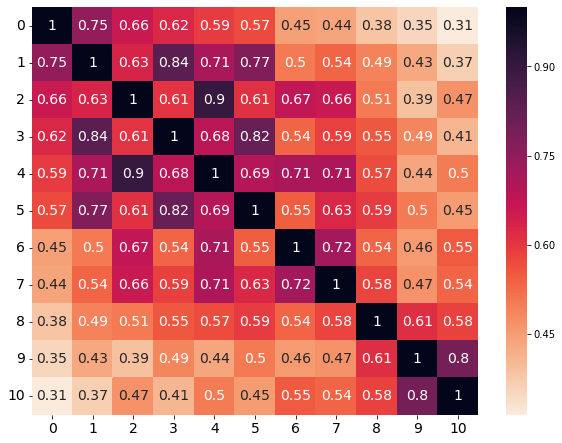

In [30]:
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NegTF_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

#### Full Positive Grapevine Dataset Network Analysis with out transformation list (analysis that will be done for each individual sample network)

Group Influence calculation (H2, CH2, O, CO and H20 with a high group influences)

In [31]:
#Group Influence in building the network
PosTF_groups = dict.fromkeys(groups, 0) #groups from the transformation list
for i in PosTF.edges():
    PosTF_groups[PosTF.edges()[i]['Transformation']] = PosTF_groups[PosTF.edges()[i]['Transformation']] + 1

PosTF_groups

{'H2': 763,
 'CH2': 1229,
 'CO2': 386,
 'O': 821,
 'CHOH': 98,
 'NCH': 289,
 'O(-NH)': 291,
 'S': 118,
 'CONH': 261,
 'PO3H': 115,
 'NH3(-O)': 214,
 'SO3': 121,
 'CO': 612,
 'C2H2O': 544,
 'H2O': 735}

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality.

In [32]:
#nx.degree(Gr)
PosTF_degree = dict(PosTF.degree())
PosTF_degree_all = sorted(PosTF_degree.items(), key=lambda kv: kv[1], reverse = True)
PosTF_degree_all[:10]

[(266.1484735477091, 18),
 (308.1955135477091, 17),
 (278.11232854770907, 17),
 (269.2710835477091, 17),
 (339.34932354770905, 16),
 (306.2162135477091, 16),
 (297.2661135477091, 16),
 (280.1279935477091, 16),
 (264.1328035477091, 16),
 (244.06178354770907, 16)]

In [33]:
PosTF_betw = nx.betweenness_centrality(PosTF)
PosTF_betw_all = sorted(PosTF_betw.items(), key=lambda kv: kv[1], reverse = True)
PosTF_betw_all[:10]

[(302.1400535477091, 0.02525623042193951),
 (284.1293635477091, 0.02471843823273458),
 (270.1139735477091, 0.02386834712018178),
 (316.1554735477091, 0.01885888215944943),
 (330.1712535477091, 0.01571472662321568),
 (346.1751535477091, 0.013125374479605878),
 (260.0931335477091, 0.012330243377034672),
 (358.1658535477091, 0.012020699939400971),
 (278.1991835477091, 0.011982974326065775),
 (298.1811735477091, 0.011939031989703544)]

In [34]:
PosTF_closeness = nx.closeness_centrality(NegTF)
PosTF_closeness_all = sorted(PosTF_closeness.items(), key=lambda kv: kv[1], reverse = True)
PosTF_closeness_all[:10]

[(342.1323964522909, 0.007006983291039845),
 (370.1271264522909, 0.006953617081664066),
 (344.1482664522909, 0.006921985768176587),
 (312.17625645229094, 0.006813506886735012),
 (326.1917864522909, 0.006688717383314958),
 (356.1113364522909, 0.006592129406660591),
 (340.2076214522909, 0.006549569030290471),
 (300.12162145229087, 0.0065401856935708574),
 (326.1377564522909, 0.0065214994487320845),
 (356.11173145229094, 0.006516844559760826)]

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets)

In [35]:
PosTF_GCD = calculating_orbits(PosTF)
PosTF_GCD_df = pd.DataFrame.from_dict(PosTF_GCD).T
PosTF_CorrMat = stats.spearmanr(PosTF_GCD_df,axis=0)[0]

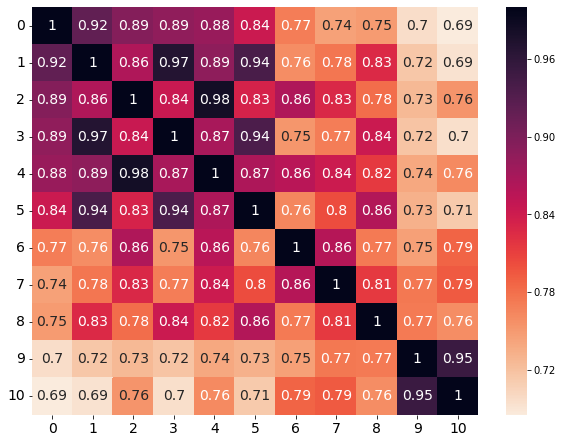

In [36]:
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(PosTF_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### NetMN (MetaNetter) - Network made with MetaNetter's list of transformations

In [37]:
#Reading the network made
NegMN_dir = nx.read_graphml('Network-NGD_MN.csv.graphml')
NegMN = NegMN_dir.to_undirected()

PosMN_dir = nx.read_graphml('Network-PGD_MN.graphml')
PosMN = PosMN_dir.to_undirected()

In [38]:
print(len(NegMN_dir.edges()),len(NegMN.edges()))
print(len(NegMN_dir.nodes()),len(NegMN.nodes()))
print(len(PosMN_dir.edges()),len(PosMN.edges()))
print(len(PosMN_dir.nodes()),len(PosMN.nodes()))

1643 1643
3629 3629
10799 10799
7026 7026


In [39]:
#Making dicts for the new names and new attribute of each node for the network
new_nodes = dict.fromkeys(NegMN.nodes(),0)

for i,j in nx.get_node_attributes(NegMN,'mass').items(): #i is old name, j is mass/new name
    new_nodes[i] = j

#Setting the new attribute formula and relabeling nodes
NegMN = nx.relabel_nodes(NegMN, mapping=new_nodes)

In [40]:
PosMN_dir = nx.read_graphml('Network-PGD_MN.graphml')
PosMN = PosMN_dir.to_undirected()
#Making dicts for the new names and new attribute of each node for the network
new_nodes = dict.fromkeys(PosMN.nodes(),0)

for i,j in nx.get_node_attributes(PosMN,'mass').items(): #i is old name, j is mass/new name
    new_nodes[i] = j

#Setting the new attribute formula and relabeling nodes
PosMN = nx.relabel_nodes(PosMN, mapping=new_nodes)

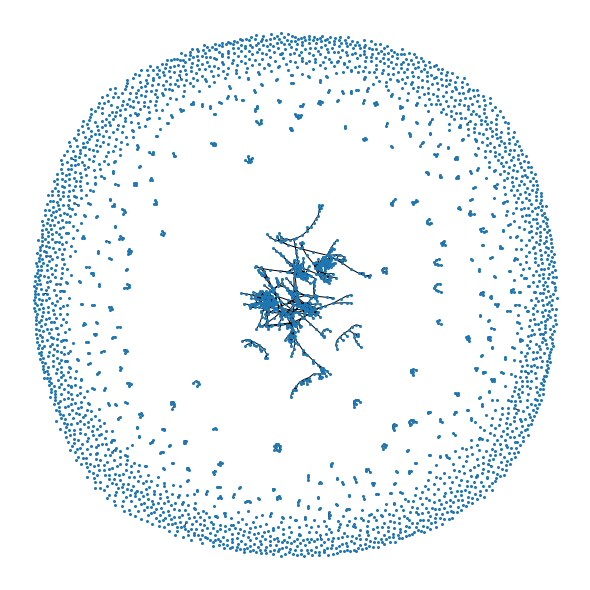

In [41]:
#Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(NegMN, node_size=4, width = 1)#, edge_color=edge_colors)
plt.show()

In [42]:
[len(c) for c in sorted(nx.connected_components(NegMN), key=len, reverse=True)][:20]

[236, 90, 50, 49, 41, 36, 27, 26, 24, 22, 19, 17, 14, 11, 10, 8, 8, 7, 7, 7]

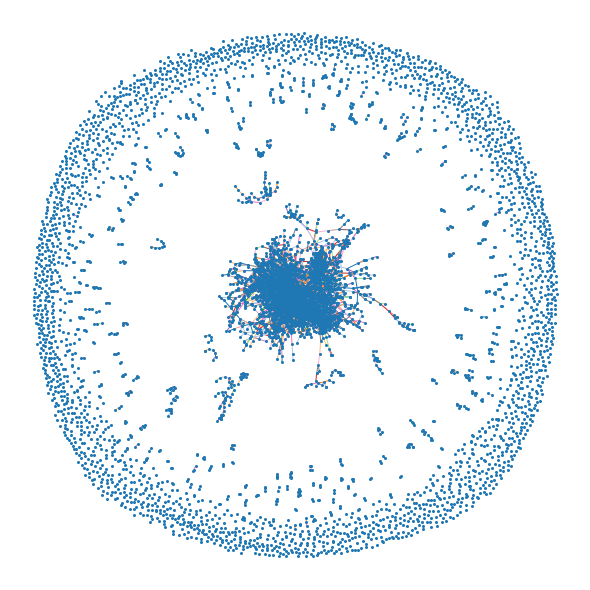

In [43]:
#Drawing the full network for the dataset
plt.figure(figsize=(8,8))
nx.draw(PosMN, node_size=4, width = 1, edge_color=edge_colors)
plt.show()

In [44]:
[len(c) for c in sorted(nx.connected_components(PosMN), key=len, reverse=True)][:20]

[3511, 26, 20, 19, 19, 17, 14, 13, 13, 11, 11, 11, 10, 9, 9, 8, 8, 8, 7, 7]

#### Full Negative Grapevine Dataset Network Analysis with MN transformation list (analysis that will be done for each individual sample network)

In [45]:
#Group Influence in building the network
NegMN_groups = dict.fromkeys(set(nx.get_edge_attributes(NegMN, 'Transformation').values()), 0) #groups from the transformation list
for i in NegMN.edges():
    NegMN_groups[NegMN.edges()[i]['Transformation']] = NegMN_groups[NegMN.edges()[i]['Transformation']] + 1

NegMN_groups

{'methanol (-H2O)': 173,
 'CHO2': 21,
 '"acetylation (-H2O), ketol group (-H2O)"': 39,
 'sulfate (-H2O)': 9,
 'Aminotransferase': 120,
 'urea addition (-H)': 13,
 'Acetyl CoA + H2O (-CoASH)': 61,
 'condensation/dehydration': 58,
 'Inorganic Phosphate': 3,
 'Formic Acid (-H2O)': 111,
 'primary amine': 28,
 'hydrogenation/dehydrogenation': 138,
 'carbamoyl P transfer (-H2PO4)': 18,
 'phosphate': 9,
 'PolyamineReactionA': 15,
 'Ethanolamine (-H2O)': 14,
 'C2H2': 82,
 'secondary amine': 37,
 'glyoxylate (-H2O)': 24,
 'tertiary amine': 46,
 'hydroxylation (-H)': 135,
 'acetone (-H)': 19,
 'isoprene addition (-H)': 13,
 'Mevalonate-5-pyrophosphate decarboxylase ': 14,
 'Carboxylation': 61,
 'Polyamine Synthase': 17,
 'Glycine': 21,
 'CO2H2': 71,
 'acetylation (-H)': 12,
 '"Ethanol (-H2O), ethyl addition (-H2O)"': 261}

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality.

In [46]:
#nx.degree(Gr)
NegMN_degree = dict(NegMN.degree())
NegMN_degree_all = sorted(NegMN_degree.items(), key=lambda kv: kv[1], reverse = True)
NegMN_degree_all[:10]

[(282.2570750322, 15),
 (344.1118950322, 13),
 (256.2412550322, 12),
 (342.0963100322, 11),
 (328.2624650322, 11),
 (284.2725350322, 11),
 (282.2567650322, 11),
 (242.22569003220002, 10),
 (597.2798450322, 9),
 (356.1118850322, 9)]

In [47]:
NegMN_betw = nx.betweenness_centrality(NegMN)
NegMN_betw_all = sorted(NegMN_betw.items(), key=lambda kv: kv[1], reverse = True)
NegMN_betw_all[:10]

[(346.1640800322, 0.001699588947028196),
 (320.0544150322, 0.0015341858055264285),
 (365.0517250322, 0.0014993279112015716),
 (336.08583003219996, 0.001475028872422519),
 (386.1955150322, 0.001300259690201718),
 (374.1590050322, 0.0012918772171727861),
 (324.1948350322, 0.0012773243914546329),
 (295.1918650322, 0.0012601495156533034),
 (267.1605650322, 0.0012548298638564313),
 (228.1371950322, 0.0010997240164647784)]

In [48]:
NegMN_closeness = nx.closeness_centrality(NegMN)
NegMN_closeness_all = sorted(NegMN_closeness.items(), key=lambda kv: kv[1], reverse = True)
NegMN_closeness_all[:10]

[(344.1118950322, 0.009287300388208315),
 (356.1118850322, 0.009191959744126465),
 (370.1276750322, 0.00916981044353821),
 (300.1217500322, 0.009153268392226957),
 (346.1273550322, 0.009147767629972011),
 (300.12217003219996, 0.009142273475239297),
 (326.1012150322, 0.009125830537334189),
 (326.1016050322, 0.009093121467307902),
 (372.1433450322, 0.009055256000162657),
 (356.11228003220003, 0.009044495149300908)]

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets)

In [49]:
NegMN_GCD = calculating_orbits(NegMN)
NegMN_GCD_df = pd.DataFrame.from_dict(NegMN_GCD).T
NegMN_CorrMat = stats.spearmanr(NegMN_GCD_df,axis=0)[0]

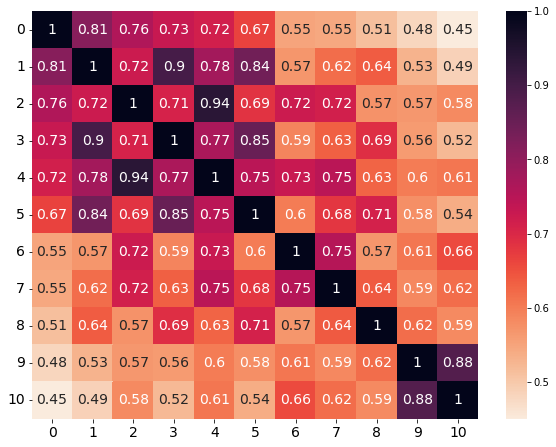

In [50]:
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(NegMN_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

#### Full Positive Grapevine Dataset Network Analysis with MN transformation list (analysis that will be done for each individual sample network)

In [51]:
#Group Influence in building the network
PosMN_groups = dict.fromkeys(set(nx.get_edge_attributes(PosMN, 'Transformation').values()), 0) #groups from the transformation list
for i in PosMN.edges():
    PosMN_groups[PosMN.edges()[i]['Transformation']] = PosMN_groups[PosMN.edges()[i]['Transformation']] + 1

PosMN_groups

{'methanol (-H2O)': 1229,
 'CHO2': 68,
 '"acetylation (-H2O), ketol group (-H2O)"': 544,
 'sulfate (-H2O)': 121,
 'Aminotransferase': 215,
 'urea addition (-H)': 128,
 'Acetyl CoA + H2O (-CoASH)': 438,
 'condensation/dehydration': 735,
 'Inorganic Phosphate': 84,
 'Formic Acid (-H2O)': 612,
 'primary amine': 121,
 'hydrogenation/dehydrogenation': 763,
 'carbamoyl P transfer (-H2PO4)': 128,
 'phosphate': 114,
 'PolyamineReactionA': 131,
 'Ethanolamine (-H2O)': 141,
 'C2H2': 646,
 'secondary amine': 257,
 'glyoxylate (-H2O)': 281,
 'tertiary amine': 115,
 'hydroxylation (-H)': 821,
 'acetone (-H)': 80,
 'isoprene addition (-H)': 77,
 'Mevalonate-5-pyrophosphate decarboxylase ': 227,
 'Carboxylation': 386,
 'Polyamine Synthase': 263,
 'Glycine': 202,
 'CO2H2': 543,
 'acetylation (-H)': 75,
 '"Ethanol (-H2O), ethyl addition (-H2O)"': 1254}

3 measures of centrality were used to analyze the networks: degree, centrality_closeness, betweenness_centrality.

In [52]:
#nx.degree(Gr)
PosMN_degree = dict(PosMN.degree())
PosMN_degree_all = sorted(PosMN_degree.items(), key=lambda kv: kv[1], reverse = True)
PosMN_degree_all[:10]

[(339.34877496779995, 27),
 (308.1949649678, 25),
 (248.1375849678, 25),
 (232.0247499678, 25),
 (280.1274449678, 24),
 (264.2189249678, 23),
 (310.1380249678, 22),
 (292.12736496779996, 22),
 (266.1117349678, 22),
 (264.1322549678, 22)]

In [53]:
PosMN_betw = nx.betweenness_centrality(PosMN)
PosMN_betw_all = sorted(PosMN_betw.items(), key=lambda kv: kv[1], reverse = True)
PosMN_betw_all[:10]

[(346.1772749678, 0.02173147898552824),
 (289.1192499678, 0.020993755371191202),
 (232.0612199678, 0.019781991942653544),
 (315.2033649678, 0.011777301060849767),
 (568.4004149678, 0.010564280937185276),
 (540.3694199678, 0.010458111292915961),
 (370.0927399678, 0.009143806243501482),
 (303.2523699678, 0.008337984012953038),
 (329.1506399678, 0.008232146007706425),
 (314.1029049678, 0.008180069682656978)]

In [54]:
PosMN_closeness = nx.closeness_centrality(PosMN)
PosMN_closeness_all = sorted(PosMN_closeness.items(), key=lambda kv: kv[1], reverse = True)
PosMN_closeness_all[:10]

[(376.28187496780004, 0.07453254949765047),
 (320.2315649678, 0.0737675986236946),
 (348.2631399678, 0.07352328385023751),
 (386.2334899678, 0.07337255834991696),
 (414.2284449678, 0.07335721293678484),
 (348.2764549678, 0.07328670663099521),
 (379.2688399678, 0.07283321108350493),
 (345.2632649678, 0.07276672709346978),
 (432.2388249678, 0.07275767049783086),
 (303.2523699678, 0.0727063923419309)]

GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets)

In [55]:
PosMN_GCD = calculating_orbits(PosMN)
PosMN_GCD_df = pd.DataFrame.from_dict(PosMN_GCD).T
PosMN_CorrMat = stats.spearmanr(PosMN_GCD_df,axis=0)[0]

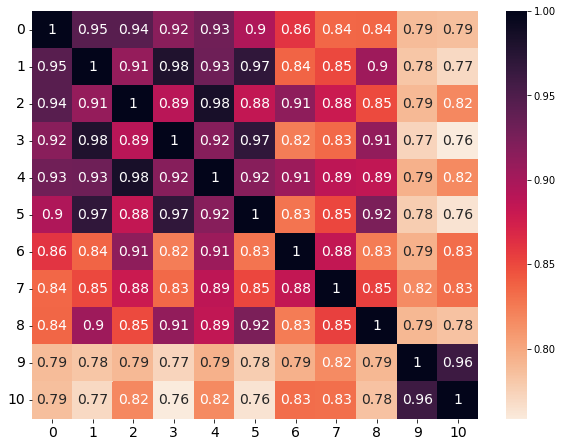

In [56]:
f, ax = plt.subplots(figsize=(10, 7.5))
hm = sns.heatmap(PosMN_CorrMat, annot=True, ax=ax, cmap = sns.cm.rocket_r, annot_kws={"size": 14})
bottom, top = ax.get_ylim()
pos, textvals = plt.yticks()
plt.yticks(np.arange(11)+0.5,(textvals), rotation=0, fontsize="10", va="center")
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize= 14)
plt.show()

### Fast Comparison between networks made with the two lists in terms of number of edges

In [57]:
print('NegTF edges:', len(NegTF.edges()), 'with 16 transformations.')
print('NegMN edges:', len(NegMN.edges()), 'with 30 transformations.')
print(len(NegMN.edges())/len(NegTF.edges())*100 - 100, '% more edges with almost double (100%) the number of groups.')

NegTF edges: 1005 with 16 transformations.
NegMN edges: 1643 with 30 transformations.
63.48258706467661 % more edges with almost double (100%) the number of groups.


In [58]:
print('PosTF edges:', len(PosTF.edges()), 'with 16 transformations.')
print('PosMN edges:', len(PosMN.edges()), 'with 30 transformations.')
print(len(PosMN.edges())/len(PosTF.edges())*100 - 100, '% more edges with almost double (100%) the number of groups.')

PosTF edges: 6597 with 16 transformations.
PosMN edges: 10799 with 30 transformations.
63.695619220857964 % more edges with almost double (100%) the number of groups.


### Why only a network for each dataset instead of a network for each sample?

The different sample networks here will be made of subgraphs of the full dataset network made (one for each transformation list). This can be done since edges only depend on the two nodes they connect. Unlike Formula_Networks, missing links who could make different edges based on the set of edges present isn't an extension here, that is, two nodes could be linked because an in-between node was missing in one sample and not in another. 

This was observed and verified to be so with 2 samples of the BY group. The network samples of these 2 samples were made and compared with the respective induced subgraphs of the full networks on the level of number of nodes, edges and group influence as well as the function of networkX is_isomorphic, all of which pointed to the fact that the networks are identical as expected.

This allows us to more efficiently and quickly create each sample network as it is done below.

## Mass Difference Sample Networks Analysis and Comparison - NetTF and NetMN

#### Creating the networks by inducing subgraphs of the main networks NetTF and NetMN (each has a dictionary)

Also adding the intensity to store in the respective nodes of each sample network

In [59]:
aligned_all_pos = aligned_all_pos.replace({np.nan:0})
aligned_all_neg = aligned_all_neg.replace({np.nan:0})

In [60]:
#Making all the graphs and storing
TF_neg = {}
TF_pos = {}
MN_neg = {}
MN_pos = {}

for n in aligned_all_neg.columns:
    j = n[0] + n[1]
    TF_neg[j] = NegTF.subgraph(aligned_all_neg[aligned_all_neg.loc[:,n] != 0].index)
    TF_pos[j] = PosTF.subgraph(aligned_all_pos[aligned_all_pos.loc[:,n] != 0].index)
    
    MN_neg[j] = NegMN.subgraph(aligned_all_neg[aligned_all_neg.loc[:,n] != 0].index + electron_mass)
    MN_pos[j] = PosMN.subgraph(aligned_all_pos[aligned_all_pos.loc[:,n] != 0].index - electron_mass)  
    
    #Storing intensity of feature in sample on the nodes
    intensity_attr = dict.fromkeys(TF_neg[j].nodes(),0)
    for i,m in nx.get_node_attributes(TF_neg[j],'mass').items():
        intensity_attr[i] = {'intensity':aligned_all_neg.loc[m,n]}
    nx.set_node_attributes(TF_neg[j],intensity_attr)
    nx.set_node_attributes(MN_neg[j],intensity_attr)

    intensity_attr = dict.fromkeys(TF_pos[j].nodes(),0)
    for i,m in nx.get_node_attributes(TF_pos[j],'mass').items():
        intensity_attr[i] = {'intensity':aligned_all_pos.loc[m,n]}
    nx.set_node_attributes(TF_pos[j],intensity_attr)
    nx.set_node_attributes(MN_pos[j],intensity_attr)
    #print(len(TF[j].nodes()),len(MN[j].nodes()))

Storing all the different analysis measures

In [61]:
#Storage for the centrality measures results
TF_neg_degree = {} 
TF_neg_betw = {}
TF_neg_closeness = {}

#Storage for the information on group influence, size of components formed and heat diffusion of the
#different graphs according to netlsd
TF_neg_groups = {}
TF_neg_components = {}
TF_neg_heat = {}

#Storage for the centrality measures results
MN_neg_degree = {} 
MN_neg_betw = {}
MN_neg_closeness = {}

#Storage for the information on group influence, size of components formed and heat diffusion of the
#different graphs according to netlsd
MN_neg_groups = {}
MN_neg_components = {}
MN_neg_heat = {}

#Storing the main centrality measures, size of the different components, group influence and heat diffusions
for j in TF_neg:
    #NetTF
    #Centrality measures
    TF_neg_degree[j] = dict(TF_neg[j].degree())
    TF_neg_betw[j] = nx.betweenness_centrality(TF_neg[j])
    TF_neg_closeness[j] = nx.closeness_centrality(TF_neg[j])
    
    #Group_influence
    TF_neg_groups[j] = dict.fromkeys(groups, 0) #groups from the transformation list
    for i in TF_neg[j].edges():
        TF_neg_groups[j][TF_neg[j].edges()[i]['Transformation']] = TF_neg_groups[j][TF_neg[j].edges()[i]['Transformation']] + 1
    
    #Only get the components > 1 (more than just an isolated node)
    TF_neg_components[j] = [len(c) for c in sorted(nx.connected_components(TF_neg[j]), key=len, reverse=True) if len(c) > 1]
    
    TF_neg_heat[j] = nl.heat(TF_neg[j])
    
    #NetMN
    #Centrality measures
    MN_neg_degree[j] = dict(MN_neg[j].degree())
    MN_neg_betw[j] = nx.betweenness_centrality(MN_neg[j])
    MN_neg_closeness[j] = nx.closeness_centrality(MN_neg[j])
    
    #Group_influence
    MN_neg_groups[j] = dict.fromkeys(set(nx.get_edge_attributes(NegMN, 'Transformation').values()), 0)
    for i in MN_neg[j].edges():
        MN_neg_groups[j][MN_neg[j].edges()[i]['Transformation']] = MN_neg_groups[j][MN_neg[j].edges()[i]['Transformation']] + 1
    
    #Only get the components > 1 (more than just an isolated node)
    MN_neg_components[j] = [len(c) for c in sorted(nx.connected_components(MN_neg[j]), key=len, reverse=True) if len(c) > 1]
    
    #MN_neg_heat[j] = nl.heat(MN_neg[j])
    print(j, 'is done')

CAN14 is done
CAN15 is done
CAN16 is done
CS29 is done
CS30 is done
CS31 is done
LAB8 is done
LAB9 is done
LAB10 is done
PN23 is done
PN24 is done
PN25 is done
REG38 is done
REG39 is done
REG40 is done
RIP17 is done
RIP18 is done
RIP19 is done
RL26 is done
RL27 is done
RL28 is done
ROT20 is done
ROT21 is done
ROT22 is done
RU35 is done
RU36 is done
RU37 is done
SYL11 is done
SYL12 is done
SYL13 is done
TRI32 is done
TRI33 is done
TRI34 is done


In [62]:
#Storage for the centrality measures results
TF_pos_degree = {} 
TF_pos_betw = {}
TF_pos_closeness = {}

#Storage for the information on group influence, size of components formed and heat diffusion of the
#different graphs according to netlsd
TF_pos_groups = {}
TF_pos_components = {}
TF_pos_heat = {}

#Storage for the centrality measures results
MN_pos_degree = {} 
MN_pos_betw = {}
MN_pos_closeness = {}

#Storage for the information on group influence, size of components formed and heat diffusion of the
#different graphs according to netlsd
MN_pos_groups = {}
MN_pos_components = {}
MN_pos_heat = {}

#Storing the main centrality measures, size of the different components, group influence and heat diffusions
for j in TF_pos:
    #NetTF
    #Centrality measures
    TF_pos_degree[j] = dict(TF_pos[j].degree())
    TF_pos_betw[j] = nx.betweenness_centrality(TF_pos[j])
    TF_pos_closeness[j] = nx.closeness_centrality(TF_pos[j])
    
    #Group_influence
    TF_pos_groups[j] = dict.fromkeys(groups, 0) #groups from the transformation list
    for i in TF_pos[j].edges():
        TF_pos_groups[j][TF_pos[j].edges()[i]['Transformation']] = TF_pos_groups[j][TF_pos[j].edges()[i]['Transformation']] + 1
    
    #Only get the components > 1 (more than just an isolated node)
    TF_pos_components[j] = [len(c) for c in sorted(nx.connected_components(TF_pos[j]), key=len, reverse=True) if len(c) > 1]
    
    #TF_pos_heat[j] = nl.heat(TF_pos[j])
    
    #NetMN
    #Centrality measures
    MN_pos_degree[j] = dict(MN_pos[j].degree())
    MN_pos_betw[j] = nx.betweenness_centrality(MN_pos[j])
    MN_pos_closeness[j] = nx.closeness_centrality(MN_pos[j])
    
    #Group_influence
    MN_pos_groups[j] = dict.fromkeys(set(nx.get_edge_attributes(PosMN, 'Transformation').values()), 0)
    for i in MN_pos[j].edges():
        MN_pos_groups[j][MN_pos[j].edges()[i]['Transformation']] = MN_pos_groups[j][MN_pos[j].edges()[i]['Transformation']] + 1
    
    #Only get the components > 1 (more than just an isolated node)
    MN_pos_components[j] = [len(c) for c in sorted(nx.connected_components(MN_pos[j]), key=len, reverse=True) if len(c) > 1]
    
    #MN_pos_heat[j] = nl.heat(MN_pos[j])
    print(j, 'is done')

CAN14 is done
CAN15 is done
CAN16 is done
CS29 is done
CS30 is done
CS31 is done
LAB8 is done
LAB9 is done
LAB10 is done
PN23 is done
PN24 is done
PN25 is done
REG38 is done
REG39 is done
REG40 is done
RIP17 is done
RIP18 is done
RIP19 is done
RL26 is done
RL27 is done
RL28 is done
ROT20 is done
ROT21 is done
ROT22 is done
RU35 is done
RU36 is done
RU37 is done
SYL11 is done
SYL12 is done
SYL13 is done
TRI32 is done
TRI33 is done
TRI34 is done


### 3 Centrality measures, Group Influence, Heat Diffusion and GCD-11 analysis

The 3 first network analysis methods focus on the characteristics of each node and each node is kept as a feature of a new dataset while the last 3 methods focus on the overall topology and structure of the network reducing drastically the number of features. By analysing in both manners, we obtained a more complete analysis of the networks and can be more confident in our results. 

Also, the last 2 methods due to their nature in comparing the topology of networks do not obtain 'neat' dataframes to use in supervised methods (although they are particularly good to obtain dendrograms). As such, some adaptations to obtain not ideal datasets have to be done - check each of them to know exactly what.

#### Note: I'm thinking of adding a last analysis method after I understand what it is - graphkernels. Despite this, there are other methods such as the distribution of degrees, and clustering coefficient which would be easy to implement, the question is which are the best methods to actual present since we can't present 100 different methods - 6 already seems plenty. 

### Obtaining the dataframes for analysis

#### Centrality measures dataframes

The analysis of each centrality measure is completely independent of each other.

In [63]:
degree_neg_TF = pd.DataFrame.from_dict(TF_neg_degree).replace({np.nan:0})
betw_neg_TF = pd.DataFrame.from_dict(TF_neg_betw).replace({np.nan:0.0})
closeness_neg_TF = pd.DataFrame.from_dict(TF_neg_closeness).replace({np.nan:0.0})

In [64]:
degree_pos_TF = pd.DataFrame.from_dict(TF_pos_degree).replace({np.nan:0})
betw_pos_TF = pd.DataFrame.from_dict(TF_pos_betw).replace({np.nan:0.0})
closeness_pos_TF = pd.DataFrame.from_dict(TF_pos_closeness).replace({np.nan:0.0})

In [65]:
degree_neg_MN = pd.DataFrame.from_dict(MN_neg_degree).replace({np.nan:0})
betw_neg_MN = pd.DataFrame.from_dict(MN_neg_betw).replace({np.nan:0.0})
closeness_neg_MN = pd.DataFrame.from_dict(MN_neg_closeness).replace({np.nan:0.0})

In [66]:
degree_pos_MN = pd.DataFrame.from_dict(MN_pos_degree).replace({np.nan:0})
betw_pos_MN = pd.DataFrame.from_dict(MN_pos_betw).replace({np.nan:0.0})
closeness_pos_MN = pd.DataFrame.from_dict(MN_pos_closeness).replace({np.nan:0.0})

In [67]:
#Example of a centrality measure dataframe
degree_pos_TF

,CAN14,CAN15,CAN16,CS29,CS30,CS31,LAB8,LAB9,LAB10,PN23,...,ROT22,RU35,RU36,RU37,SYL11,SYL12,SYL13,TRI32,TRI33,TRI34
408.174674,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
408.304004,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0
409.307374,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
410.235899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410.423154,0.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,...,1.0,4.0,4.0,4.0,1.0,1.0,1.0,3.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470.176529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476.397174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498.551454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500.516539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Group Influence Dataframes

Transform the dictionary of dictionaries with the Group Influence stats into a dataframe. Now, it can be analysed together with the binary dataframes made above. The analysis performed will be the same than for the rest of dataframes, however, for this dataframe the distance measure used in hierarchical clustering is euclidean and not a binary measure such as the jaccard distance since this dataframe is not binary.

#### What is "Group Influence" in this context?

Each group that represents a set of chemical reactions has a value attached in every network built. This number corresponds to the amount of edges that were established between two formulas that used this group, that is, the amount of times one of the set of chemical reactions can transform a formula into another (a metabolite into another).

This value then should represent the importance of the group in establishing the network when compared to the rest of the groups. The bigger the value, the higher the impact of that group in establishing the network. 

Here we test if the importance of these groups in establishing the overall network is characteristic of the strain of the sample.

We also can see the overall "usefullness" of each group in building the networks. 

In [68]:
groups_neg_TF = pd.DataFrame.from_dict(TF_neg_groups)
groups_neg_MN = pd.DataFrame.from_dict(MN_neg_groups)
groups_pos_TF = pd.DataFrame.from_dict(TF_pos_groups)
groups_pos_MN = pd.DataFrame.from_dict(MN_pos_groups)
groups_pos_TF

,CAN14,CAN15,CAN16,CS29,CS30,CS31,LAB8,LAB9,LAB10,PN23,...,ROT22,RU35,RU36,RU37,SYL11,SYL12,SYL13,TRI32,TRI33,TRI34
H2,24,37,26,55,58,64,35,37,34,125,...,16,146,145,163,47,11,26,135,135,158
CH2,68,110,74,119,118,137,120,119,110,238,...,43,270,259,308,110,65,74,219,237,292
CO2,9,14,12,22,30,25,17,10,12,56,...,7,68,59,74,14,3,6,57,58,74
O,15,31,18,56,54,70,30,30,30,128,...,19,160,149,187,40,15,22,134,152,163
CHOH,0,3,1,5,2,3,1,1,1,8,...,0,8,12,11,1,0,1,10,5,10
NCH,4,10,7,13,16,20,7,6,11,33,...,5,49,49,60,4,5,5,30,35,40
O(-NH),4,8,4,20,16,19,5,4,10,40,...,2,49,45,54,10,2,3,36,41,48
S,0,4,0,1,1,0,6,8,4,8,...,1,8,9,8,2,0,2,11,8,12
CONH,1,2,0,3,5,4,6,4,4,36,...,2,33,28,37,7,3,4,15,19,32
PO3H,1,4,0,5,3,6,3,2,5,6,...,0,5,8,9,4,2,2,7,5,11


In [69]:
groups_neg_TF = groups_neg_TF/groups_neg_TF.sum()*100
groups_pos_TF = groups_pos_TF/groups_pos_TF.sum()*100

### GCD-11 Analysis - Graphlet Correlation Distance of 11 different orbits (maximum of 4 node graphlets) - (Needs verification)

#### Explanation in Formula_Networks


In [70]:
TF_neg_CorrMat = {}
for i in TF_neg:
    #For 1 network
    orbits_t = calculating_orbits(TF_neg[i]) #Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T #Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] #Calculating spearman correlation to obtain 11x11 signature of the network - GCM.
    corrMat_ar[np.isnan(corrMat_ar)] = 0
    TF_neg_CorrMat[i] = np.triu(corrMat_ar) #Both parts of the matrix are equal, so reducing the info to the upper triangle.

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [71]:
TF_neg_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

for i in TF_neg_CorrMat:
    samp_col = {}
    for u in range(len(TF_neg_CorrMat[i])):
        for v in range(u+1, len(TF_neg_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = TF_neg_CorrMat[i][u,v]
        TF_neg_CorrMat_df[i] = samp_col
#Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_neg_TF = pd.DataFrame.from_dict(TF_neg_CorrMat_df)
#corrMat_neg_TF

In [72]:
TF_pos_CorrMat = {}
for i in MN_pos:
    #For 1 network
    orbits_t = calculating_orbits(TF_pos[i]) #Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T #Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] #Calculating spearman correlation to obtain 11x11 signature of the network - GCM.
    corrMat_ar[np.isnan(corrMat_ar)] = 0
    TF_pos_CorrMat[i] = np.triu(corrMat_ar) #Both parts of the matrix are equal, so reducing the info to the upper triangle.

In [73]:
TF_pos_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

for i in TF_pos_CorrMat:
    samp_col = {}
    for u in range(len(TF_pos_CorrMat[i])):
        for v in range(u+1, len(TF_pos_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = TF_pos_CorrMat[i][u,v]
        TF_pos_CorrMat_df[i] = samp_col
#Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_pos_TF = pd.DataFrame.from_dict(TF_pos_CorrMat_df)
#corrMat_TF_pos

In [74]:
MN_neg_CorrMat = {}
for i in MN_neg:
    #For 1 network
    orbits_t = calculating_orbits(MN_neg[i]) #Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T #Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] #Calculating spearman correlation to obtain 11x11 signature of the network - GCM.
    corrMat_ar[np.isnan(corrMat_ar)] = 0
    MN_neg_CorrMat[i] = np.triu(corrMat_ar) #Both parts of the matrix are equal, so reducing the info to the upper triangle.

In [75]:
MN_neg_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

for i in MN_neg_CorrMat:
    samp_col = {}
    for u in range(len(MN_neg_CorrMat[i])):
        for v in range(u+1, len(MN_neg_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = MN_neg_CorrMat[i][u,v]
        MN_neg_CorrMat_df[i] = samp_col
#Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_neg_MN = pd.DataFrame.from_dict(MN_neg_CorrMat_df)
corrMat_neg_MN

,CAN14,CAN15,CAN16,CS29,CS30,CS31,LAB8,LAB9,LAB10,PN23,...,ROT22,RU35,RU36,RU37,SYL11,SYL12,SYL13,TRI32,TRI33,TRI34
0-1,0.798421,0.794340,0.769354,0.760594,0.739890,0.758719,0.749683,0.794852,0.836816,0.825151,...,0.815488,0.765804,0.719988,0.708263,0.781929,0.802765,0.788571,0.775780,0.541937,0.746818
0-2,0.656254,0.640459,0.636123,0.631502,0.633932,0.630041,0.602983,0.644594,0.680556,0.723863,...,0.697246,0.629004,0.600015,0.602779,0.672349,0.651105,0.643760,0.651144,0.431238,0.636282
0-4,0.688014,0.614404,0.599173,0.700214,0.670731,0.678111,0.567025,0.641605,0.712796,0.713510,...,0.731867,0.642161,0.636168,0.626271,0.684005,0.679491,0.655380,0.672937,0.350564,0.657215
0-5,0.594490,0.579792,0.540673,0.614004,0.605051,0.599409,0.532753,0.560343,0.632277,0.626325,...,0.674654,0.580813,0.559548,0.545961,0.629177,0.614363,0.587688,0.610193,0.331923,0.602781
0-6,0.580206,0.534030,0.547127,0.594686,0.575964,0.608522,0.495212,0.488718,0.607236,0.634823,...,0.576189,0.444896,0.472872,0.524655,0.581579,0.425574,0.464648,0.559120,0.289913,0.585484
0-7,0.376486,0.349142,0.383195,0.422000,0.407769,0.411693,0.372499,0.330362,0.447592,0.490027,...,0.387878,0.307918,0.316701,0.326058,0.405246,0.283539,0.309015,0.348312,0.195220,0.402100
0-8,0.324474,0.242477,0.290097,0.299825,0.316378,0.326450,0.312841,0.286634,0.307246,0.477313,...,0.364148,0.250253,0.142302,0.219471,0.343181,0.220438,0.271877,0.358139,0.153866,0.394227
0-9,0.551912,0.401522,0.526374,0.530420,0.502332,0.514708,0.458048,0.523022,0.582273,0.498675,...,0.525121,0.339270,0.362766,0.464165,0.523526,0.575975,0.491004,0.467557,0.097505,0.509818
0-10,0.535870,0.438378,0.519066,0.550478,0.500177,0.507549,0.494778,0.511796,0.523638,0.543395,...,0.543367,0.404140,0.420267,0.482911,0.510977,0.577643,0.509077,0.507668,0.136011,0.518764
0-11,0.421707,0.349159,0.427914,0.461817,0.440169,0.428383,0.375718,0.403110,0.463723,0.482595,...,0.468437,0.339750,0.345087,0.398704,0.421629,0.515676,0.424412,0.437639,0.112152,0.436092


In [76]:
MN_pos_CorrMat = {}
for i in MN_pos:
    #For 1 network
    orbits_t = calculating_orbits(MN_pos[i]) #Calculating orbit number for each node
    orbits_df = pd.DataFrame.from_dict(orbits_t).T #Transforming into a dataframe
    
    corrMat_ar = stats.spearmanr(orbits_df)[0] #Calculating spearman correlation to obtain 11x11 signature of the network - GCM.
    corrMat_ar[np.isnan(corrMat_ar)] = 0
    MN_pos_CorrMat[i] = np.triu(corrMat_ar) #Both parts of the matrix are equal, so reducing the info to the upper triangle.

In [77]:
MN_pos_CorrMat_df = {}
orbits = [0,1,2,4,5,6,7,8,9,10,11] #orbit names

for i in MN_pos_CorrMat:
    samp_col = {}
    for u in range(len(MN_pos_CorrMat[i])):
        for v in range(u+1, len(MN_pos_CorrMat[i])):
            samp_col[str(orbits[u]) + '-' + str(orbits[v])] = MN_pos_CorrMat[i][u,v]
        MN_pos_CorrMat_df[i] = samp_col
#Each row of the dataframe will be orbit_u-orbit_v correlation
corrMat_pos_MN = pd.DataFrame.from_dict(MN_pos_CorrMat_df)
#corrMat_MN_pos

##### Global metadata for consistency between tables and plots

Finally, only now are the labels of each group added making the dataframe a CDL Accessor.

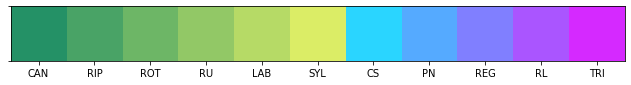

In [78]:
labels = list(aligned_all_pos.cdl.labels)

mtl.add_labels(degree_neg_TF, labels = labels)
mtl.add_labels(betw_neg_TF, labels = labels)
mtl.add_labels(closeness_neg_TF, labels = labels)
mtl.add_labels(groups_neg_TF, labels = labels)
#mtl.add_labels(heat_neg_TF, labels = labels)
mtl.add_labels(corrMat_neg_TF, labels = labels)

mtl.add_labels(degree_neg_MN, labels = labels)
mtl.add_labels(betw_neg_MN, labels = labels)
mtl.add_labels(closeness_neg_MN, labels = labels)
mtl.add_labels(groups_neg_MN, labels = labels)
#mtl.add_labels(heat_neg_MN, labels = labels)
mtl.add_labels(corrMat_neg_MN, labels = labels)

mtl.add_labels(degree_pos_TF, labels = labels)
mtl.add_labels(betw_pos_TF, labels = labels)
mtl.add_labels(closeness_pos_TF, labels = labels)
mtl.add_labels(groups_pos_TF, labels = labels)
#mtl.add_labels(heat_pos_TF, labels = labels)
mtl.add_labels(corrMat_pos_TF, labels = labels)

mtl.add_labels(degree_pos_MN, labels = labels)
mtl.add_labels(betw_pos_MN, labels = labels)
mtl.add_labels(closeness_pos_MN, labels = labels)
mtl.add_labels(groups_pos_MN, labels = labels)
#mtl.add_labels(heat_pos_MN, labels = labels)
mtl.add_labels(corrMat_pos_MN, labels = labels)

sample_names = degree_neg_TF.cdl.samples
all_labels = degree_neg_TF.cdl.labels
unique_labels = degree_neg_TF.cdl.unique_labels

# customize these colors
colours = sns.color_palette('summer', 6)
colours.extend(sns.color_palette('cool', 5))
ordered_unique_labels = ('CAN','RIP','ROT','RU','LAB','SYL','CS','PN','REG','RL','TRI')

label_colors = {lbl: c for lbl, c in zip(ordered_unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(ordered_unique_labels)), ordered_unique_labels)

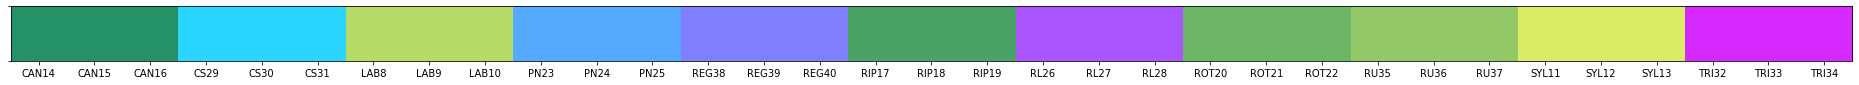

In [79]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Statistical Analysis and Discrimination of all sample Networks made

### Hierarchical Cluster Analysis (agglomerative)

HCA analysis and plotting 7 dendrograms based on the 6 dataframes built - degree, betweenness centrality, closeness centrality, sum of the 3 prior distance matrices, group influence and heat diffusion (already a distance matrix in this case, the distance matrix is used since no better option is available).

In [80]:
def plot_dendogram(Z, title='', color_threshold = None):
    fig = plt.figure(figsize=(10,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=13, above_threshold_color='b', color_threshold = color_threshold)
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 16)
    xlbls = ax.get_xmajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])
    plt.rcParams['lines.linewidth'] = 1

### NetTF - Transformation List - Negative

Centrality measures Dendrograms

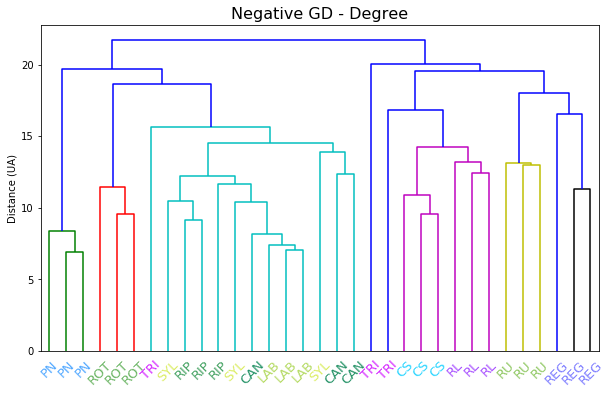

In [81]:
degree_neg_TF_df_dist = dist.pdist(degree_neg_TF.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z_degree_neg_TF = hier.linkage(degree_neg_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_neg_TF, degree_neg_TF_df_dist)[0]

title = f'Negative GD - Degree'
plot_dendogram(Z_degree_neg_TF, title, color_threshold=16)
#plt.savefig('Net-Dendro-NGD-Degree')

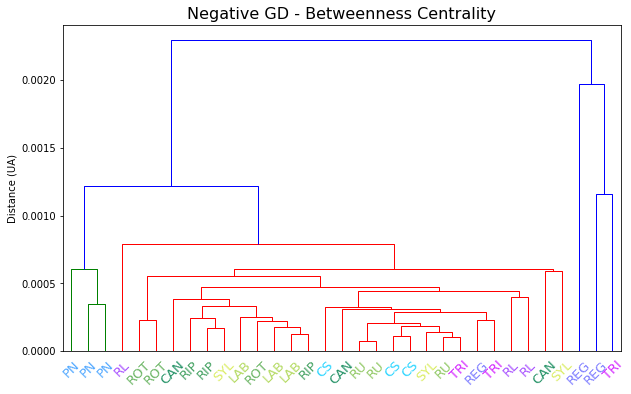

In [82]:
betw_neg_TF_df_dist = dist.pdist(betw_neg_TF.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z_betw_neg_TF = hier.linkage(betw_neg_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_neg_TF, betw_neg_TF_df_dist)[0]

title = f'Negative GD - Betweenness Centrality'
plot_dendogram(Z_betw_neg_TF, title, color_threshold = 0.001)
#plt.savefig('Net-Dendro-NGD-Betw')

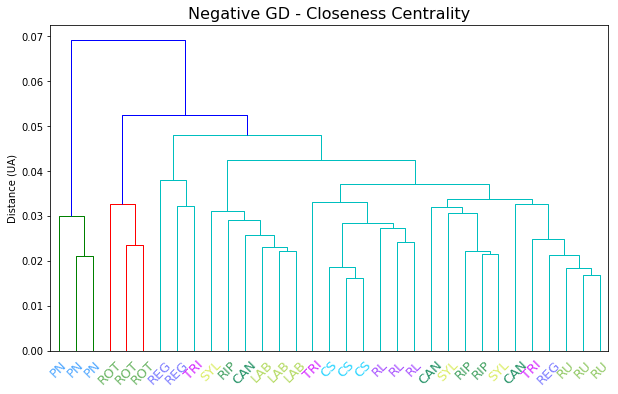

In [83]:
closeness_neg_TF_df_dist = dist.pdist(closeness_neg_TF.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z_closeness_neg_TF = hier.linkage(closeness_neg_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_neg_TF, closeness_neg_TF_df_dist)[0]

title = f'Negative GD - Closeness Centrality'
plot_dendogram(Z_closeness_neg_TF, title)
#plt.savefig('Net-Dendro-NGD-Closeness')

Group Influence Dendrogram

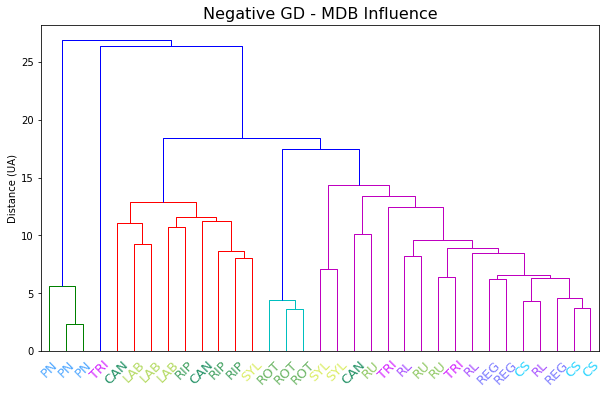

In [84]:
groups_neg_TF_df_dist = dist.pdist(groups_neg_TF.T, metric='euclidean')
Z_groups_neg_TF = hier.linkage(groups_neg_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_groups_neg_TF, groups_neg_TF_df_dist)[0] #method average seems to lead to higher coefficients

title = f'Negative GD - MDB Influence'
plot_dendogram(Z_groups_neg_TF, title, color_threshold=17)
#plt.savefig('Net-Dendro-NGD-Group')

GCD-11 Dendrogram

In [85]:
corrMat_neg_TF_df_dist = dist.pdist(corrMat_neg_TF.T)

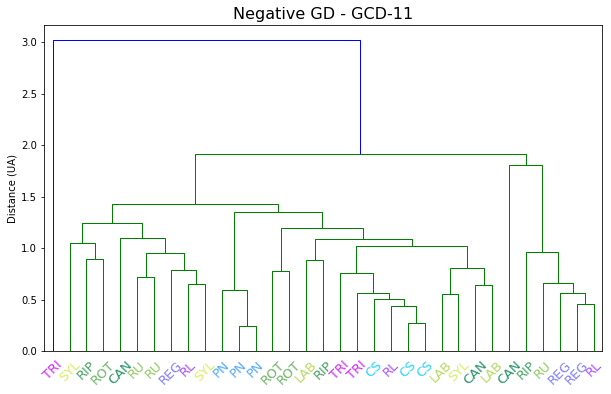

In [86]:
Z_GCD_neg_TF = hier.linkage(corrMat_neg_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_neg_TF, corrMat_neg_TF_df_dist)[0] #method average seems to lead to higher coefficients

title = f'Negative GD - GCD-11'
plot_dendogram(Z_GCD_neg_TF, title)
#plt.savefig('Net-Dendro-NGD-GCD-11')

### NetTF - Transformation List - Positive

Centrality measures Dendrograms

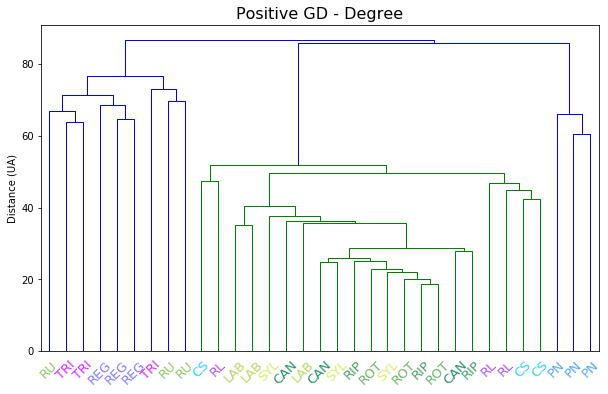

In [87]:
degree_pos_TF_df_dist = dist.pdist(degree_pos_TF.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z_degree_pos_TF = hier.linkage(degree_pos_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_pos_TF, degree_pos_TF_df_dist)[0]

title = f'Positive GD - Degree'
plot_dendogram(Z_degree_pos_TF, title)
#plt.savefig('Net-Dendro-PGD-degree')

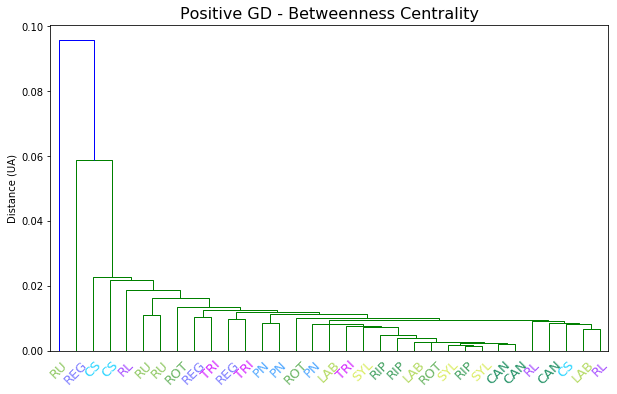

In [88]:
betw_pos_TF_df_dist = dist.pdist(betw_pos_TF.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z_betw_pos_TF = hier.linkage(betw_pos_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_pos_TF, betw_pos_TF_df_dist)[0]

title = f'Positive GD - Betweenness Centrality'
plot_dendogram(Z_betw_pos_TF, title)
#plt.savefig('Net-Dendro-PGD-betw')

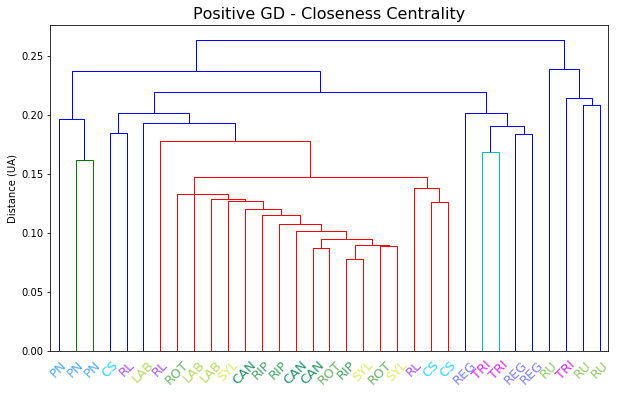

In [89]:
closeness_pos_TF_df_dist = dist.pdist(closeness_pos_TF.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z_closeness_pos_TF = hier.linkage(closeness_pos_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_pos_TF, closeness_pos_TF_df_dist)[0]

title = f'Positive GD - Closeness Centrality'
plot_dendogram(Z_closeness_pos_TF, title)
#plt.savefig('Net-Dendro-PGD-closeness')

Group Influence Dendrogram

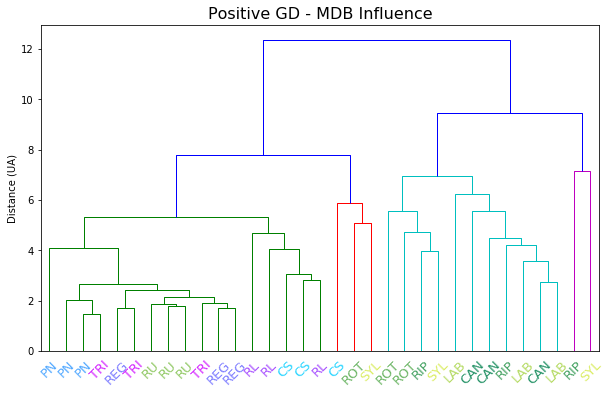

In [90]:
groups_pos_TF_df_dist = dist.pdist(groups_pos_TF.T, metric='euclidean')
Z_groups_pos_TF = hier.linkage(groups_pos_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_groups_pos_TF, groups_pos_TF_df_dist)[0] #method average seems to lead to higher coefficients

title = f'Positive GD - MDB Influence'
plot_dendogram(Z_groups_pos_TF, title, color_threshold=7.5)
#plt.savefig('Net-Dendro-PGD-group')

GCD-11 Dendrogram

In [91]:
corrMat_pos_TF_df_dist = dist.pdist(corrMat_pos_TF.T)

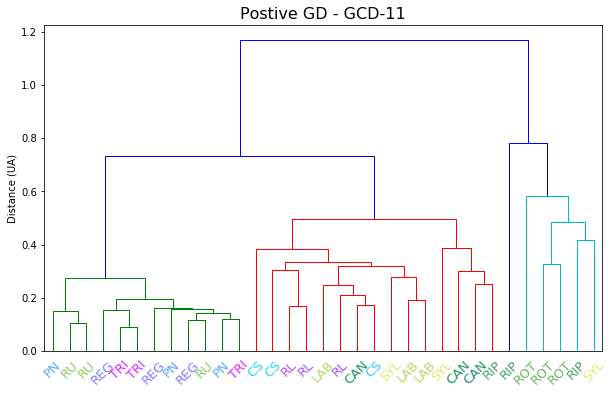

In [92]:
Z_GCD_pos_TF = hier.linkage(corrMat_pos_TF_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_pos_TF, corrMat_pos_TF_df_dist)[0] #method average seems to lead to higher coefficients

title = f'Postive GD - GCD-11'
plot_dendogram(Z_GCD_pos_TF, title, color_threshold = 0.65)
#plt.savefig('Net-Dendro-PGD-GCD-11')

### NetMN - MetaNetter - Negative

Centrality measures Dendrograms

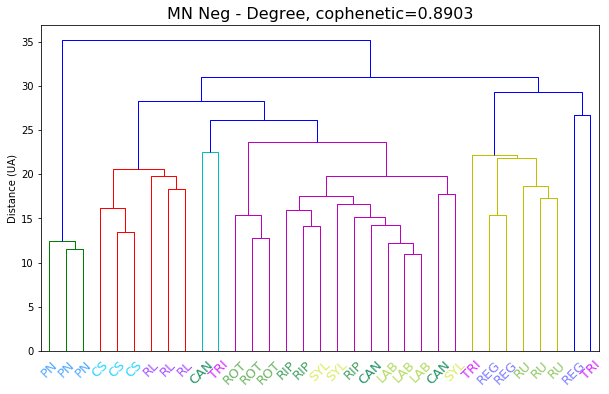

In [93]:
degree_neg_MN_df_dist = dist.pdist(degree_neg_MN.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z_degree_neg_MN = hier.linkage(degree_neg_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_neg_MN, degree_neg_MN_df_dist)[0]

title = f'MN Neg - Degree, cophenetic={coph:.4f}'
plot_dendogram(Z_degree_neg_MN, title)

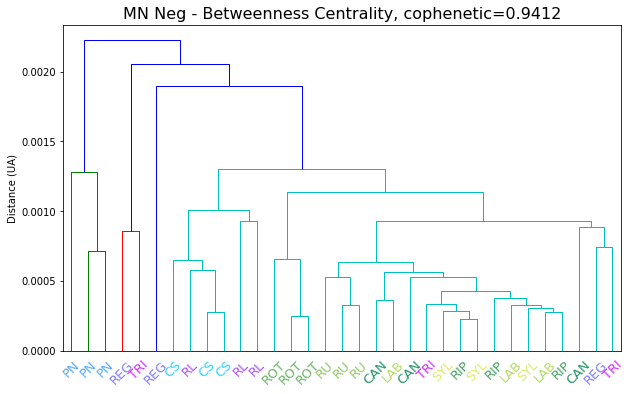

In [94]:
betw_neg_MN_df_dist = dist.pdist(betw_neg_MN.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z_betw_neg_MN = hier.linkage(betw_neg_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_neg_MN, betw_neg_MN_df_dist)[0]

title = f'MN Neg - Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_betw_neg_MN, title)

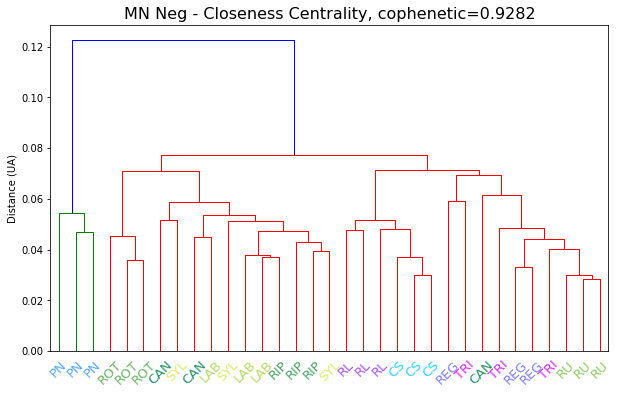

In [95]:
closeness_neg_MN_df_dist = dist.pdist(closeness_neg_MN.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z_closeness_neg_MN = hier.linkage(closeness_neg_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_neg_MN, closeness_neg_MN_df_dist)[0]

title = f'MN Neg - Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_closeness_neg_MN, title)

Group Influence Dendrogram

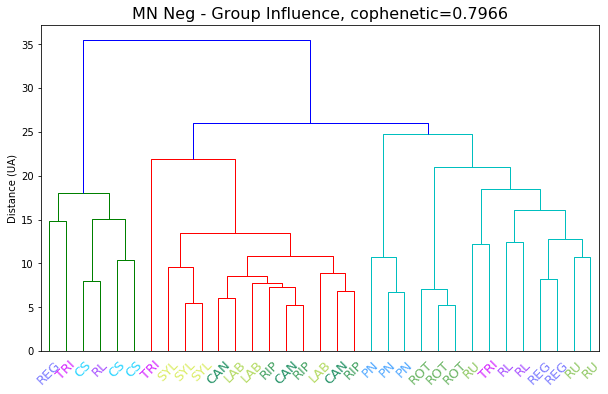

In [96]:
groups_neg_MN_df_dist = dist.pdist(groups_neg_MN.T, metric='euclidean')
Z_groups_neg_MN = hier.linkage(groups_neg_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_groups_neg_MN, groups_neg_MN_df_dist)[0] #method average seems to lead to higher coefficients

title = f'MN Neg - Group Influence, cophenetic={coph:.4f}'
plot_dendogram(Z_groups_neg_MN, title)

GCD-11 Dendrogram

In [97]:
corrMat_neg_MN_df_dist = dist.pdist(corrMat_neg_MN.T)

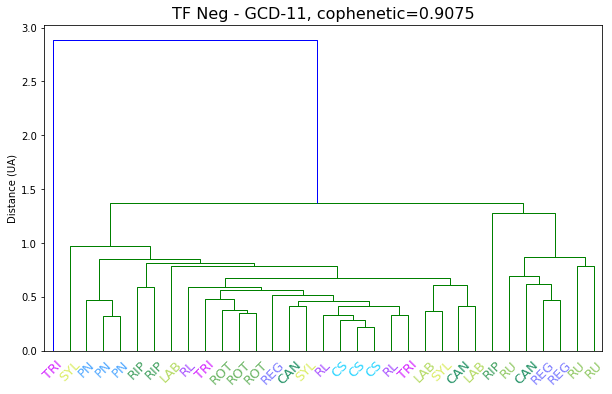

In [98]:
Z_GCD_neg_MN = hier.linkage(corrMat_neg_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_neg_MN, corrMat_neg_MN_df_dist)[0] #method average seems to lead to higher coefficients

title = f'TF Neg - GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z_GCD_neg_MN, title)

### NetMN - MetaNetter - Positive

Centrality measures Dendrograms

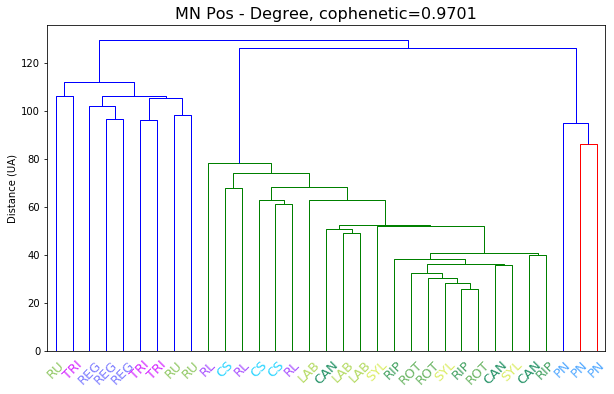

In [99]:
degree_pos_MN_df_dist = dist.pdist(degree_pos_MN.T, metric='euclidean')
#degree_df_jdist = dist.pdist(degree_df.T, metric='jaccard')
Z_degree_pos_MN = hier.linkage(degree_pos_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_degree_pos_MN, degree_pos_MN_df_dist)[0]

title = f'MN Pos - Degree, cophenetic={coph:.4f}'
plot_dendogram(Z_degree_pos_MN, title)

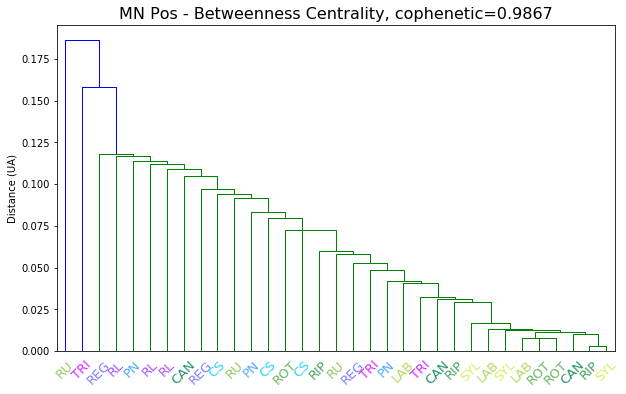

In [100]:
betw_pos_MN_df_dist = dist.pdist(betw_pos_MN.T, metric='euclidean')
#betw_df_jdist = dist.pdist(betw_df.T, metric='jaccard')
Z_betw_pos_MN = hier.linkage(betw_pos_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_betw_pos_MN, betw_pos_MN_df_dist)[0]

title = f'MN Pos - Betweenness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_betw_pos_MN, title)

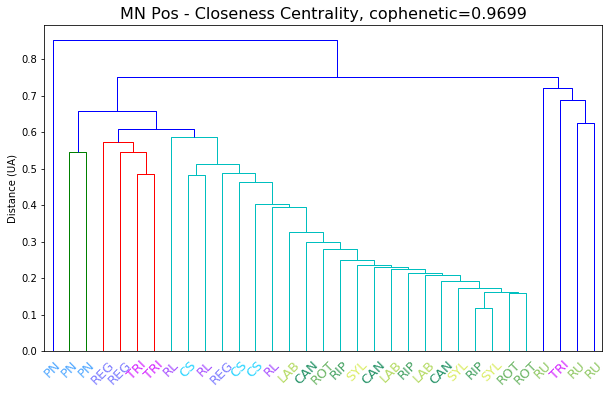

In [101]:
closeness_pos_MN_df_dist = dist.pdist(closeness_pos_MN.T, metric='euclidean')
#closeness_df_jdist = dist.pdist(closeness_df.T, metric='jaccard')
Z_closeness_pos_MN = hier.linkage(closeness_pos_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_closeness_pos_MN, closeness_pos_MN_df_dist)[0]

title = f'MN Pos - Closeness Centrality, cophenetic={coph:.4f}'
plot_dendogram(Z_closeness_pos_MN, title)

Group Influence Dendrogram

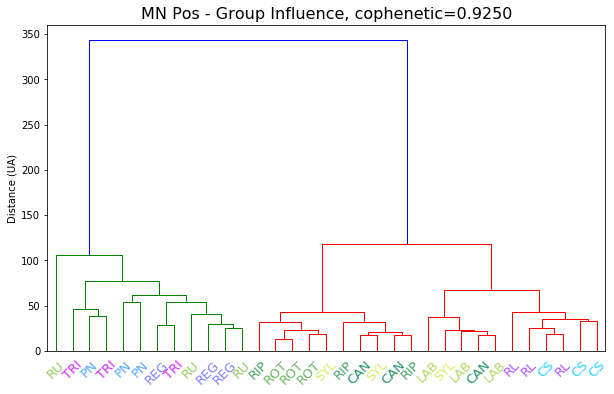

In [102]:
groups_pos_MN_df_dist = dist.pdist(groups_pos_MN.T, metric='euclidean')
Z_groups_pos_MN = hier.linkage(groups_pos_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_groups_pos_MN, groups_pos_MN_df_dist)[0] #method average seems to lead to higher coefficients

title = f'MN Pos - Group Influence, cophenetic={coph:.4f}'
plot_dendogram(Z_groups_pos_MN, title)

GCD-11 Dendrogram

In [103]:
corrMat_pos_MN_df_dist = dist.pdist(corrMat_pos_MN.T)

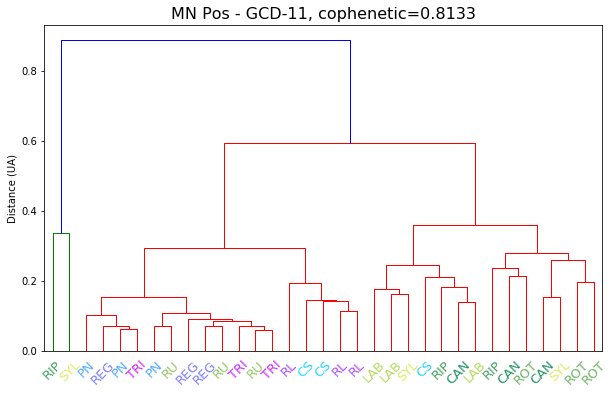

In [104]:
Z_GCD_pos_MN = hier.linkage(corrMat_pos_MN_df_dist, method='average')

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_GCD_pos_MN, corrMat_pos_MN_df_dist)[0] #method average seems to lead to higher coefficients

title = f'MN Pos - GCD-11, cophenetic={coph:.4f}'
plot_dendogram(Z_GCD_pos_MN, title)

### Comparing HCA Discrimination

In [105]:
Z = (Z_degree_neg_TF, Z_betw_neg_TF, Z_closeness_neg_TF, Z_groups_neg_TF, Z_GCD_neg_TF,
     Z_degree_pos_TF, Z_betw_pos_TF, Z_closeness_pos_TF, Z_groups_pos_TF, Z_GCD_pos_TF,
    Z_degree_neg_MN, Z_betw_neg_MN, Z_closeness_neg_MN, Z_groups_neg_MN, Z_GCD_neg_MN,
    Z_degree_pos_MN, Z_betw_pos_MN, Z_closeness_pos_MN, Z_groups_pos_MN, Z_GCD_pos_MN)

dists = (degree_neg_TF_df_dist, betw_neg_TF_df_dist, closeness_neg_TF_df_dist, groups_neg_TF_df_dist, corrMat_neg_TF_df_dist,
         degree_pos_TF_df_dist, betw_pos_TF_df_dist, closeness_pos_TF_df_dist, groups_pos_TF_df_dist, corrMat_pos_TF_df_dist,
        degree_neg_MN_df_dist, betw_neg_MN_df_dist, closeness_neg_MN_df_dist, groups_neg_MN_df_dist, corrMat_neg_MN_df_dist,
        degree_pos_MN_df_dist, betw_pos_MN_df_dist, closeness_pos_MN_df_dist, groups_pos_MN_df_dist, corrMat_pos_MN_df_dist)

colnames = ['Degree_neg_TF', 'Betweenness_neg_TF', ' Closeness_neg_TF', 'Group Influence_neg_TF', 'GCD-11_neg_TF',
            'Degree_pos_TF', 'Betweenness_pos_TF', ' Closeness_pos_TF', 'Group Influence_pos_TF', 'GCD-11_pos_TF',
           'Degree_neg_MN', 'Betweenness_neg_MN', ' Closeness_neg_MN', 'Group Influence_neg_MN',  'GCD-11_neg_MN',
           'Degree_pos_MN', 'Betweenness_pos_MN', ' Closeness_pos_MN', 'Group Influence_pos_MN',  'GCD-11_pos_MN']

In [106]:
disc_average = np.zeros((1,20))
disc_median = np.zeros((1,20))
disc_correct = np.zeros((1,20))
disc_goodclust = np.zeros((1,20))

for i in range(len(Z)):
    data = degree_neg_TF
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    disc_goodclust[0,i] = ma.good_first_cluster_fraction(data, Z[i]) #all samples have the same order
    
#Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)
disc_goodclust = pd.DataFrame(disc_goodclust, index = ['% good 1st cluster'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,10:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,10:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,10:]], axis = 1)
disc_goodclust = pd.concat([disc_goodclust.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% good 1st cluster']).T, disc_goodclust.iloc[:,10:]], axis = 1)

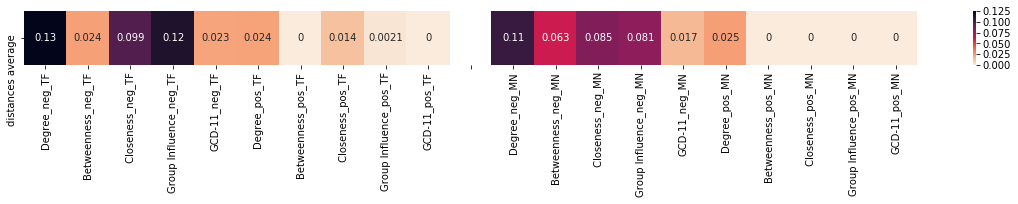

In [107]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

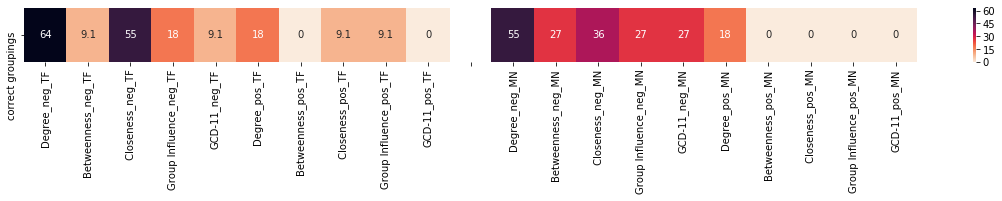

In [108]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct*100/11, annot=True, ax=ax, cmap = sns.cm.rocket_r)

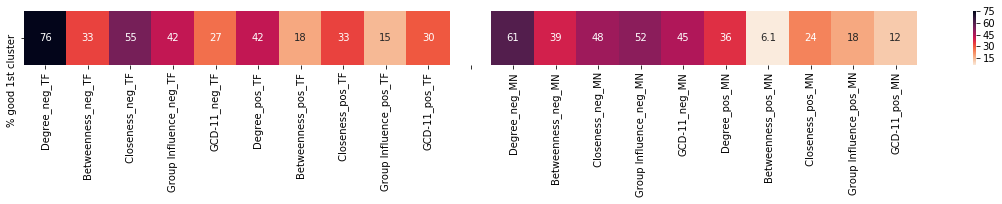

In [109]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_goodclust*100, annot=True, ax=ax, cmap = sns.cm.rocket_r)

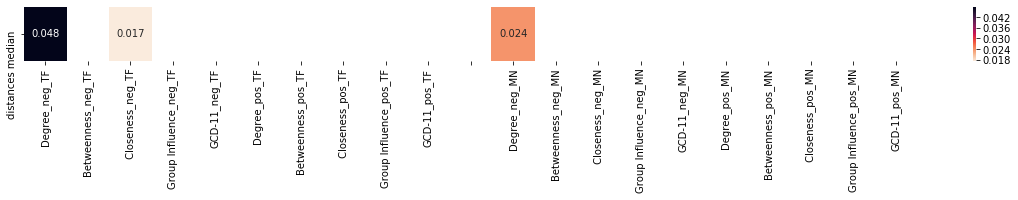

In [110]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [111]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [112]:
Kmean = skclust.KMeans(n_clusters=11)

In [113]:
a = Kmean.fit(degree_neg_TF.T)
a.inertia_

1497.047619047619

In [114]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{0: ['CAN', 'CAN', 'RIP', 'RIP', 'SYL', 'SYL', 'TRI'],
 6: ['CAN', 'LAB', 'LAB', 'LAB', 'RIP', 'SYL'],
 1: ['CS', 'CS', 'CS'],
 2: ['PN', 'PN', 'PN'],
 10: ['REG'],
 3: ['REG', 'REG'],
 5: ['RL', 'RL', 'RL'],
 7: ['ROT', 'ROT', 'ROT'],
 4: ['RU', 'RU', 'RU'],
 9: ['TRI'],
 8: ['TRI']}

### K-means clustering applied to all networks

Use of the `Kmeans_discrim` function from multianalysis to calculate the different metrics.

In [115]:
Data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, groups_neg_TF, corrMat_neg_TF,
        degree_pos_TF, betw_pos_TF, closeness_pos_TF, groups_pos_TF, corrMat_pos_TF,
       degree_neg_MN, betw_neg_MN, closeness_neg_MN, groups_neg_MN, corrMat_neg_MN,
       degree_pos_MN, betw_pos_MN, closeness_pos_MN, groups_pos_MN, corrMat_pos_MN)

In [116]:
ali = ma.Kmeans(corrMat_neg_TF.cdl.data, n_labels=11,iter_num=21,best_fraction=0.1)

dicto = {}
for i, lbl in enumerate(ali[0][0].labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{9: ['CAN', 'REG', 'RL', 'RU', 'SYL'],
 7: ['CAN'],
 10: ['CAN', 'LAB', 'LAB'],
 1: ['CS', 'CS', 'CS', 'RL', 'TRI', 'TRI'],
 8: ['LAB', 'RIP'],
 6: ['PN', 'PN', 'PN'],
 2: ['REG', 'REG', 'RIP', 'RL', 'RU'],
 3: ['RIP', 'ROT', 'SYL'],
 5: ['ROT', 'ROT', 'SYL'],
 0: ['RU'],
 4: ['TRI']}

In [117]:
disc_average = np.zeros((1,20))
#disc_median = np.zeros((1,20))
disc_correct = np.zeros((1,20))
disc_rand = np.zeros((1,20))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    #Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) #Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) #Correct Clustering Percentages
        rand.append(discrim[j][2]) #Rand Index
    
    #Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

#Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct/11*100, index = ['correct groupings'], columns = colnames)
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,10:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,10:]], axis = 1)
disc_rand = pd.concat([disc_rand.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Rand Index']).T, disc_rand.iloc[:,10:]], axis = 1)

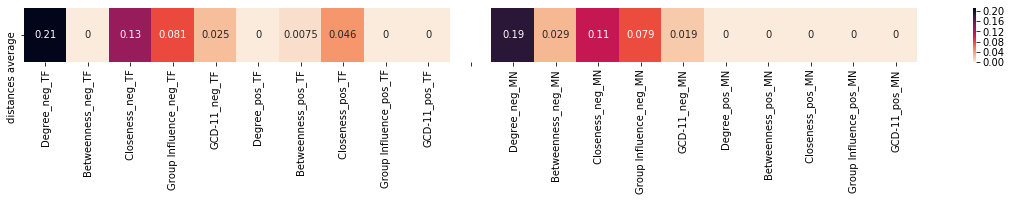

In [118]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

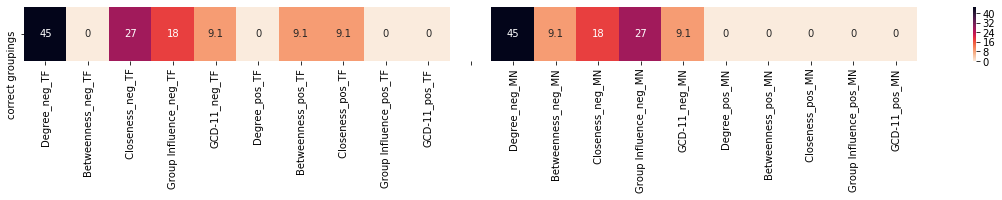

In [119]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

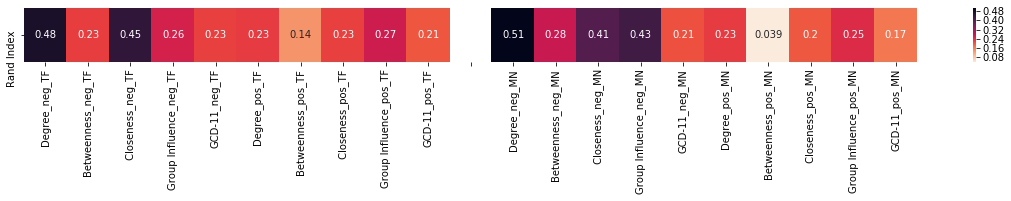

In [120]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [121]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [122]:
disc_average

,Degree_neg_TF,Betweenness_neg_TF,Closeness_neg_TF,Group Influence_neg_TF,GCD-11_neg_TF,Degree_pos_TF,Betweenness_pos_TF,Closeness_pos_TF,Group Influence_pos_TF,GCD-11_pos_TF,...,Degree_neg_MN,Betweenness_neg_MN,Closeness_neg_MN,Group Influence_neg_MN,GCD-11_neg_MN,Degree_pos_MN,Betweenness_pos_MN,Closeness_pos_MN,Group Influence_pos_MN,GCD-11_pos_MN
distances average,0.213008,0.0,0.131812,0.081138,0.025187,0.0,0.007461,0.04603,0.0,0.0,...,0.188922,0.029121,0.109192,0.079206,0.018743,0.0,0.0,0.0,0.0,0.0


## Supervised analysis

The datasets that will be analyzed:

In [123]:
datasets = {'Degree': degree_neg_TF, 'Betweenness': betw_neg_TF, 'Closeness' : closeness_neg_TF, 
            'Group Inf.': groups_neg_TF, 'GCD-11': corrMat_neg_TF,
            'TF_pos_degree': degree_pos_TF, 'TF_pos_betweenness': betw_pos_TF, 'TF_pos_closeness' : closeness_pos_TF, 
            'TF_pos_groups': groups_pos_TF, 'TF_pos_GCD-11': corrMat_pos_TF}#,
            #'MN_neg_degree': degree_neg_MN, 'MN_neg_betweenness': betw_neg_MN, 'MN_neg_closeness' : closeness_neg_MN, 
            #'MN_neg_groups': groups_neg_MN, 'MN_neg_GCD-11': corrMat_neg_MN,
            #'MN_pos_degree': degree_pos_MN, 'MN_pos_betweenness': betw_pos_MN, 'MN_pos_closeness' : closeness_pos_MN, 
            #'MN_pos_groups': groups_pos_MN, 'MN_pos_GCD-11': corrMat_pos_MN}

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

In [124]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,400,2)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [125]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting Degree ... Done!
Fitting Betweenness ... Done!
Fitting Closeness ... Done!
Fitting Group Inf. ... Done!
Fitting GCD-11 ... Done!
Fitting TF_pos_degree ... Done!
Fitting TF_pos_betweenness ... Done!
Fitting TF_pos_closeness ... Done!
Fitting TF_pos_groups ... Done!
Fitting TF_pos_GCD-11 ... Done!


Text(0.5, 1.0, 'Negative Grapevine Dataset')

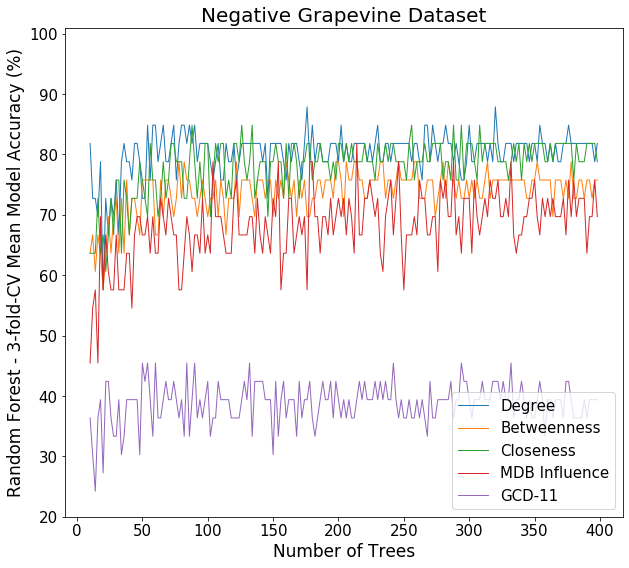

In [126]:
f, ax = plt.subplots(figsize=(10,9))
for i in range(5):
    plt.plot(param[i], test_score[i]*100)
plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('Degree', 'Betweenness', 'Closeness', 'MDB Influence', 'GCD-11'), fontsize=15, loc='lower right')
plt.ylim(20,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Negative Grapevine Dataset', fontsize=20)

Text(0.5, 1.0, 'Positive Grapevine Dataset')

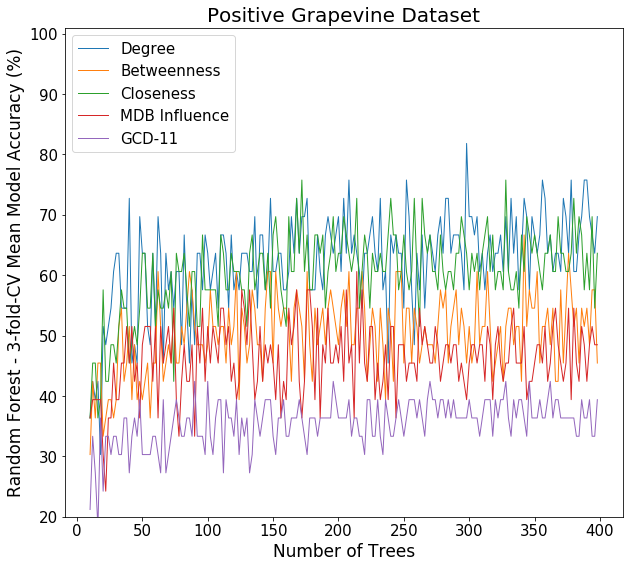

In [127]:
f, ax = plt.subplots(figsize=(10,9))
for i in range(5,10):
    plt.plot(param[i], test_score[i]*100)
plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('Degree', 'Betweenness', 'Closeness', 'MDB Influence', 'GCD-11'), fontsize=15, loc='upper left')
plt.ylim(20,101)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Positive Grapevine Dataset', fontsize=20)

### Random Forests

Application of the Random Forests

In [128]:
# Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, iter_num=200)
    #, iter_num = 100) #(Scores, Cohen's Kappa Score, order of features based on importances, 3-fold cross-validation)
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')    

Fitting random forest for Degree ...done
Fitting random forest for Betweenness ...done
Fitting random forest for Closeness ...done
Fitting random forest for Group Inf. ...done
Fitting random forest for GCD-11 ...done
Fitting random forest for TF_pos_degree ...done
Fitting random forest for TF_pos_betweenness ...done
Fitting random forest for TF_pos_closeness ...done
Fitting random forest for TF_pos_groups ...done
Fitting random forest for TF_pos_GCD-11 ...done


Performance of each predictive model

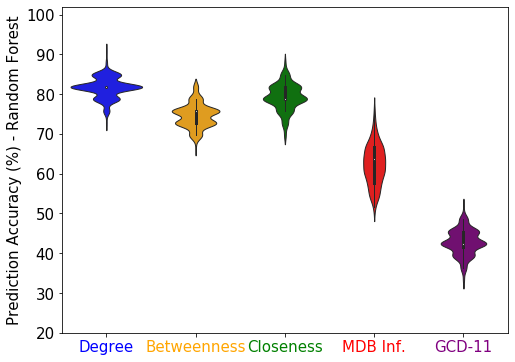

In [129]:
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(Scores).iloc[:,:5] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red','purple']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([20,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.savefig('Net-RF-NGD')

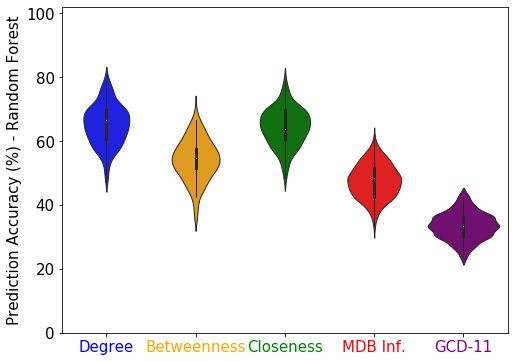

In [130]:
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(Scores).iloc[:,5:] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red','purple']
sns.violinplot( data = data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([0,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
#plt.savefig('Net-RF-PGD')

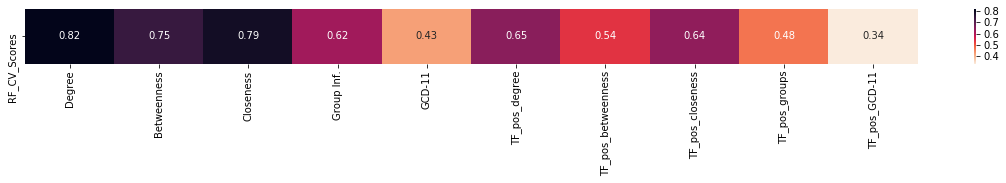

In [131]:
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])

Scores_H = pd.DataFrame(list(Scores_A.values()), index = Scores_A.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

In [132]:
Scores_A

{'Degree': 0.8166666666666668,
 'Betweenness': 0.7463636363636366,
 'Closeness': 0.7931818181818181,
 'Group Inf.': 0.6233333333333334,
 'GCD-11': 0.4277272727272727,
 'TF_pos_degree': 0.6503030303030303,
 'TF_pos_betweenness': 0.5409090909090909,
 'TF_pos_closeness': 0.6434848484848485,
 'TF_pos_groups': 0.47545454545454535,
 'TF_pos_GCD-11': 0.335}

In [133]:
Imp_feat['TF_pos_groups'] #Important groups whose influence can be characteristic of each network
featu2 = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
featu2 = featu2.set_index('Place')
n=1
for i,j,m in Imp_feat['TF_pos_groups']:
    featu2.loc[n]= m,j
    n= n+1
featu2

,MDB,Gini Importance
Place,,
1,O,0.085548
2,CONH,0.082109
3,NH3(-O),0.076658
4,CH2,0.074981
5,H2O,0.071424
6,CO,0.069084
7,NCH,0.068586
8,O(-NH),0.068013
9,CO2,0.067967


In [134]:
Imp_feat['Group Inf.']

[(3, 0.08742292742969784, 'O'),
 (0, 0.08628101585911505, 'H2'),
 (10, 0.08432489887008812, 'NH3(-O)'),
 (2, 0.08157217311181478, 'CO2'),
 (11, 0.07911163339402101, 'SO3'),
 (1, 0.07819050843297538, 'CH2'),
 (12, 0.07624697943742423, 'CO'),
 (13, 0.0724109628469297, 'C2H2O'),
 (8, 0.06823725117479015, 'CONH'),
 (5, 0.06441303252562641, 'NCH'),
 (14, 0.058766715625288214, 'H2O'),
 (6, 0.05630757004712604, 'O(-NH)'),
 (9, 0.04527351048525338, 'PO3H'),
 (4, 0.04017330109843855, 'CHOH'),
 (7, 0.02126751966141141, 'S')]

In [135]:
Imp_feat['TF_pos_groups'] #Important groups whose influence can be characteristic of each network
featu = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
featu = featu.set_index('Place')
n=1
for i,j,m in Imp_feat['Group Inf.']:
    featu.loc[n]= m,j
    n= n+1
featu

,MDB,Gini Importance
Place,,
1,O,0.087423
2,H2,0.086281
3,NH3(-O),0.084325
4,CO2,0.081572
5,SO3,0.079112
6,CH2,0.078191
7,CO,0.076247
8,C2H2O,0.072411
9,CONH,0.068237


### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

All analysis is similar to the ones performed in similarity_analysis notebooks.

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [136]:
matrix = pd.get_dummies(all_labels)
matrix

,CAN,CS,LAB,PN,REG,RIP,RL,ROT,RU,SYL,TRI
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,0


#### Search for the best number of components to use

In [137]:
%%capture --no-stdout
PLS_optim = {}
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    if name.endswith('egree') or name.endswith('loseness'):
        CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 30)
    else:
        CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 10)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for Degree ...done
Optimizing PLS-DA for Betweenness ...done
Optimizing PLS-DA for Closeness ...done
Optimizing PLS-DA for Group Inf. ...done
Optimizing PLS-DA for GCD-11 ...done
Optimizing PLS-DA for TF_pos_degree ...done
Optimizing PLS-DA for TF_pos_betweenness ...done
Optimizing PLS-DA for TF_pos_closeness ...done
Optimizing PLS-DA for TF_pos_groups ...done
Optimizing PLS-DA for TF_pos_GCD-11 ...done


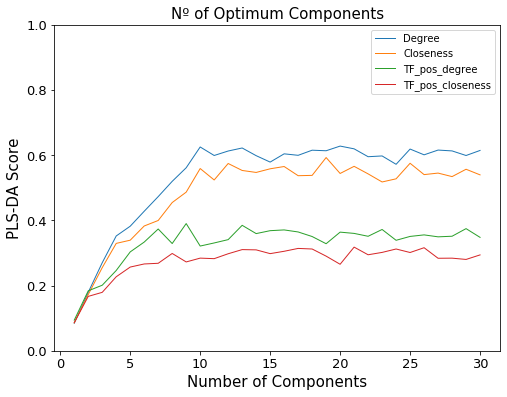

In [138]:
f, ax = plt.subplots(figsize=(8,6))

legend = []
for name, data in PLS_optim.items():
    if data[-1] > 0.2:
        plt.plot(range(1,31),data)
        legend.append(name)
        
    
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('PLS-DA Score', fontsize=15)
plt.title('Nº of Optimum Components', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(legend)
plt.ylim([0,1])
plt.show()

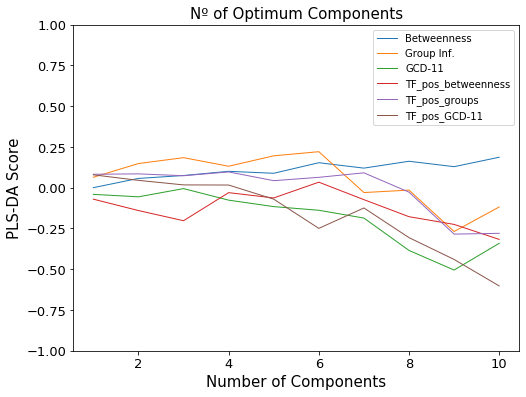

In [139]:
f, ax = plt.subplots(figsize=(8,6))

legend = []
for name, data in PLS_optim.items():
    if data[9] < 0.2:
        plt.plot(range(1,11),data)
        legend.append(name)
        
plt.ylim([-1,1])
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('PLS-DA Score', fontsize=15)
plt.title('Nº of Optimum Components', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(legend)
plt.show()

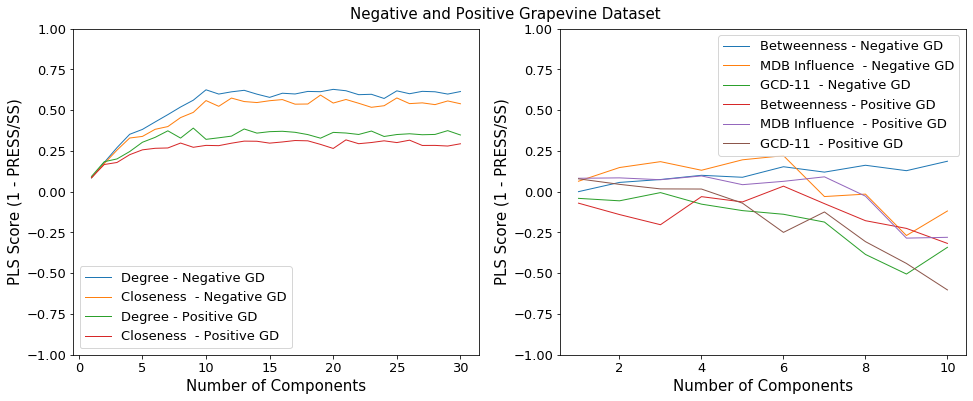

In [140]:
f, axes = plt.subplots(1, 2, figsize = (16,6))
quadrant = [axes[0], axes[1]]
plt.suptitle('Negative and Positive Grapevine Dataset', fontsize = 15, x = 0.5, y = 0.93)
for name, data in PLS_optim.items():
    if data[-1] > 0.2:
        quadrant[0].plot(range(1,31),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        #quadrant[0].set_title('Negative and Positive Grapevine Dataset', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('Degree - Negative GD', 'Closeness  - Negative GD', 'Degree - Positive GD', 'Closeness  - Positive GD'), fontsize=13)
        quadrant[0].set_ylim([-1, 1])
    else:
        quadrant[1].plot(range(1,11),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS Score (1 - PRESS/SS)', fontsize=15)
        #quadrant[1].set_title('Negative and Positive Grapevine Dataset', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('Betweenness - Negative GD', 'MDB Influence  - Negative GD', 'GCD-11  - Negative GD',
                            'Betweenness - Positive GD', 'MDB Influence  - Positive GD', 'GCD-11  - Positive GD'), fontsize=13)
        quadrant[1].set_ylim([-1, 1])

#### Application of PLS-DA

In [141]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [142]:
%%capture --no-stdout

for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    if name.endswith('egree') or name.endswith('loseness'):
        accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 11, iter_num = 200)#, feat_type = 'VIP')
    else:
        accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 5, iter_num = 200)#, feat_type = 'VIP')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done') 

Fitting PLS-DA for Degree ...done
Fitting PLS-DA for Betweenness ...done
Fitting PLS-DA for Closeness ...done
Fitting PLS-DA for Group Inf. ...done
Fitting PLS-DA for GCD-11 ...done
Fitting PLS-DA for TF_pos_degree ...done
Fitting PLS-DA for TF_pos_betweenness ...done
Fitting PLS-DA for TF_pos_closeness ...done
Fitting PLS-DA for TF_pos_groups ...done
Fitting PLS-DA for TF_pos_GCD-11 ...done


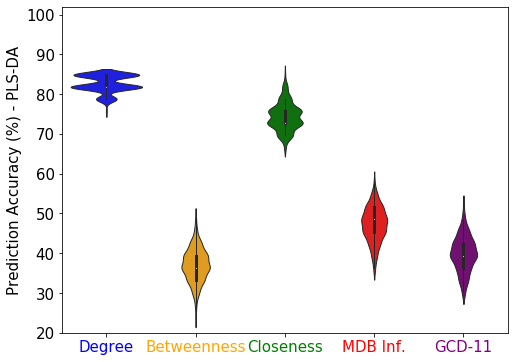

In [143]:
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(PLS_accu).iloc[:,:5] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red', 'purple']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([20,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
    
#plt.savefig('Net-PLSDA-NGD')

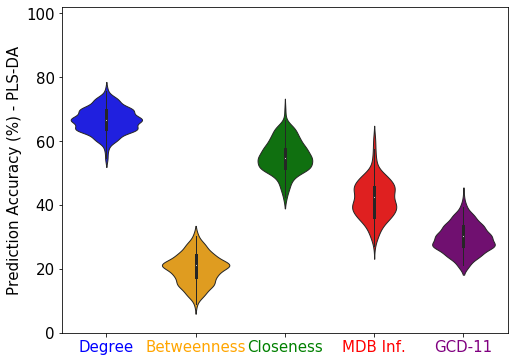

In [144]:
f, ax = plt.subplots(figsize=(8,6))
data = pd.DataFrame.from_dict(PLS_accu).iloc[:,5:] * 100
data.columns = ['Degree', 'Betweenness', 'Closeness', 'MDB Inf.', 'GCD-11']
colors = ['blue','orange','green','red', 'purple']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([0,102])
ax.tick_params(axis='x', which='major', labelsize = 15)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)
    
#plt.savefig('Net-PLSDA-PGD')

Accuracy based on the dataset


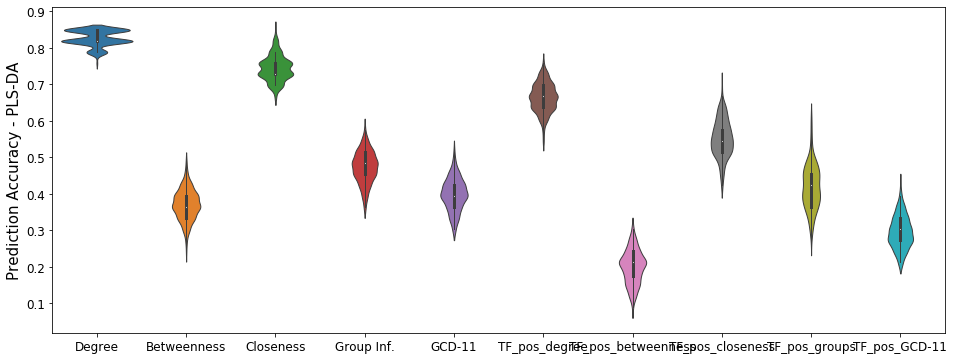

In [145]:
f, ax = plt.subplots(figsize=(16,6))
data=pd.DataFrame.from_dict(PLS_accu)
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:10], alpha = 0.5)#palette = colors, 
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 12)
print('Accuracy based on the dataset')

In [147]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

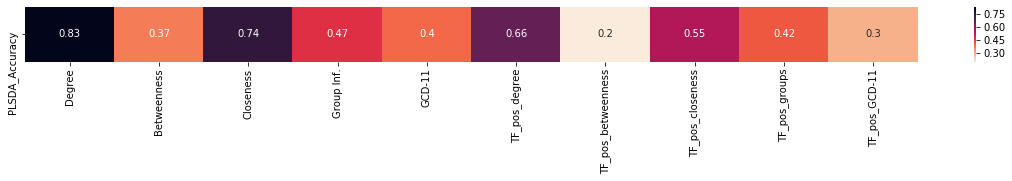

In [148]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

In [149]:
Accuracy_H

,Degree,Betweenness,Closeness,Group Inf.,GCD-11,TF_pos_degree,TF_pos_betweenness,TF_pos_closeness,TF_pos_groups,TF_pos_GCD-11
0,0.826515,0.370758,0.743939,0.47303,0.398788,0.664242,0.200303,0.552273,0.418788,0.295152


In [150]:
PLS_feat['TF_pos_groups'] #s and CONH still useless. The main contriuting groups are different from the ones in Random Forests.
featu4 = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
featu4 = featu4.set_index('Place')
n=1
for i,j,m in PLS_feat['TF_pos_groups']:
    featu4.loc[n]= m,j
    n= n+1
featu4

,MDB,Gini Importance
Place,,
1,H2O,0.429979
2,CONH,0.402478
3,O,0.386995
4,CO,0.325604
5,CO2,0.323535
6,H2,0.300299
7,NCH,0.299416
8,O(-NH),0.293063
9,C2H2O,0.269658


In [151]:
PLS_feat['Group Inf.']
featu3 = pd.DataFrame(columns=['Place', 'MDB', 'Gini Importance'])
featu3 = featu3.set_index('Place')
n=1
for i,j,m in PLS_feat['Group Inf.']:
    featu3.loc[n]= m,j
    n= n+1
featu3

,MDB,Gini Importance
Place,,
1,NCH,0.211316
2,CHOH,0.132844
3,O,0.131138
4,C2H2O,0.129082
5,NH3(-O),0.116302
6,H2,0.111545
7,CO,0.108692
8,CO2,0.084169
9,CH2,0.082290


### Permutation Tests - PLS-DA

In [152]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, groups_neg_TF, corrMat_neg_TF,
            degree_pos_TF, betw_pos_TF, closeness_pos_TF, groups_pos_TF, corrMat_pos_TF,
            degree_neg_MN, betw_neg_MN, closeness_neg_MN, groups_neg_MN, corrMat_neg_MN,
            degree_pos_MN, betw_pos_MN, closeness_pos_MN, groups_pos_MN, corrMat_pos_MN,)
names = ('TF_neg_Degree', 'TF_neg_Betweenness', 'TF_neg_Closeness', 'TF_neg_Groups', 'TF_neg_GCD-11',
         'TF_pos_Degree', 'TF_pos_Betweenness', 'TF_pos_Closeness', 'TF_pos_Groups', 'TF_pos_GCD-11',
         'MN_neg_Degree', 'MN_neg_Betweenness', 'MN_neg_Closeness', 'MN_neg_Groups', 'MN_neg_GCD-11',
         'MN_pos_Degree', 'MN_pos_Betweenness', 'MN_pos_Closeness', 'MN_pos_Groups', 'MN_pos_GCD-11',)

all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, groups_neg_TF, corrMat_neg_TF,
            degree_pos_TF, betw_pos_TF, closeness_pos_TF, groups_pos_TF, corrMat_pos_TF)
names = ('Degree - Negative GD', 'Betweenness', 'Closeness', 'Groups', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_Groups', 'pos_GCD-11')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    if name.endswith('degree') or name.endswith('closeness'):
        permuta = ma.permutation_PLSDA(data, n_comp=11, iter_num=1000)
    else:
        permuta = ma.permutation_PLSDA(data, n_comp=5, iter_num=1000)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Degree - Negative GD ...
Done!
permutation test (PLS-DA) for Betweenness ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for Closeness ...
Done!
permutation test (PLS-DA) for Groups ...
Done!
permutation test (PLS-DA) for GCD-11 ...
Done!
permutation test (PLS-DA) for pos_Degree ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for pos_Betweenness ...
Done!
permutation test (PLS-DA) for pos_Closeness ...
Done!
permutation test (PLS-DA) for pos_Groups ...
Done!
permutation test (PLS-DA) for pos_GCD-11 ...
Done!


In [153]:
CV_PLS['Group Inf.'] = CV_PLS['Groups']
PMs_PLS['Group Inf.'] = PMs_PLS['Groups']
pvalue_PLS['Group Inf.'] = pvalue_PLS['Groups']

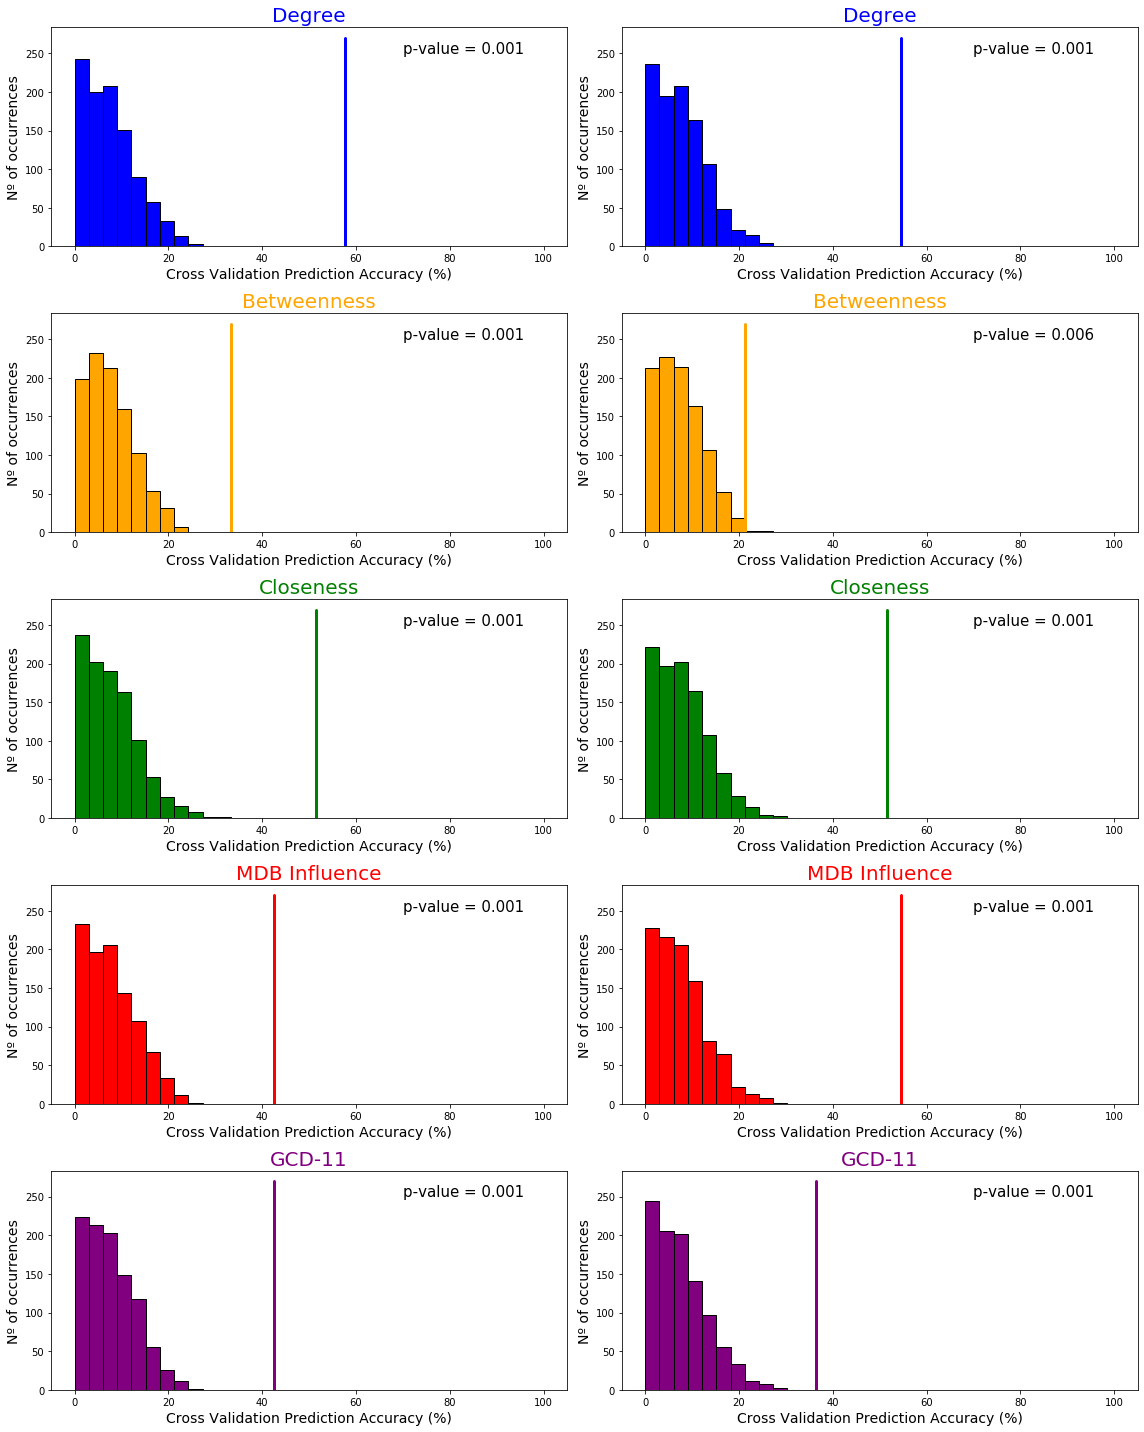

In [154]:
f, axes = plt.subplots(5, 2, figsize = (16,20))

Names = ['Degree - Negative GD', 'Betweenness', 'Closeness', 'Group Inf.', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_Groups', 'pos_GCD-11']
colors = ['blue', 'orange', 'green', 'red', 'purple'] * 2
quadrant = [axes[0][0], axes[1][0], axes[2][0], axes[3][0], axes[4][0],
           axes[0][1], axes[1][1], axes[2][1], axes[3][1], axes[4][1]]
ylim = [0,270]
n_labels = len(degree_neg_TF.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(70,250, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    if name.startswith('pos'):
        name = name.split('_')[-1]
        if name == 'Groups':
            name = 'MDB Influence'
    elif name.endswith('GD'):
        name = name.split(' ')[0]
    elif name == 'Group Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-GD-PLSDA')

### Permutation Tests - Random Forests

In [156]:
CV = {}
PMs = {}
pvalue = {}

all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, groups_neg_TF, corrMat_neg_TF,
            degree_pos_TF, betw_pos_TF, closeness_pos_TF, groups_pos_TF, corrMat_pos_TF,
            degree_neg_MN, betw_neg_MN, closeness_neg_MN, groups_neg_MN, corrMat_neg_MN,
            degree_pos_MN, betw_pos_MN, closeness_pos_MN, groups_pos_MN, corrMat_pos_MN,)
names = ('TF_neg_Degree', 'TF_neg_Betweenness', 'TF_neg_Closeness', 'TF_neg_Groups', 'TF_neg_GCD-11',
         'TF_pos_Degree', 'TF_pos_Betweenness', 'TF_pos_Closeness', 'TF_pos_Groups', 'TF_pos_GCD-11',
         'MN_neg_Degree', 'MN_neg_Betweenness', 'MN_neg_Closeness', 'MN_neg_Groups', 'MN_neg_GCD-11',
         'MN_pos_Degree', 'MN_pos_Betweenness', 'MN_pos_Closeness', 'MN_pos_Groups', 'MN_pos_GCD-11',)

all_data = (degree_neg_TF, betw_neg_TF, closeness_neg_TF, groups_neg_TF, corrMat_neg_TF,
            degree_pos_TF, betw_pos_TF, closeness_pos_TF, groups_pos_TF, corrMat_pos_TF)
names = ('Degree', 'Betweenness', 'Closeness', 'Groups', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_Groups', 'pos_GCD-11')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=100, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Degree ...
Done!
Permutation test (Random Forest) for Betweenness ...
Done!
Permutation test (Random Forest) for Closeness ...
Done!
Permutation test (Random Forest) for Groups ...
Done!
Permutation test (Random Forest) for GCD-11 ...
Done!
Permutation test (Random Forest) for pos_Degree ...
Done!
Permutation test (Random Forest) for pos_Betweenness ...
Done!
Permutation test (Random Forest) for pos_Closeness ...
Done!
Permutation test (Random Forest) for pos_Groups ...
Done!
Permutation test (Random Forest) for pos_GCD-11 ...
Done!


In [157]:
CV['Group Inf.'] = CV['Groups']
PMs['Group Inf.'] = PMs['Groups']
pvalue['Group Inf.'] = pvalue['Groups']

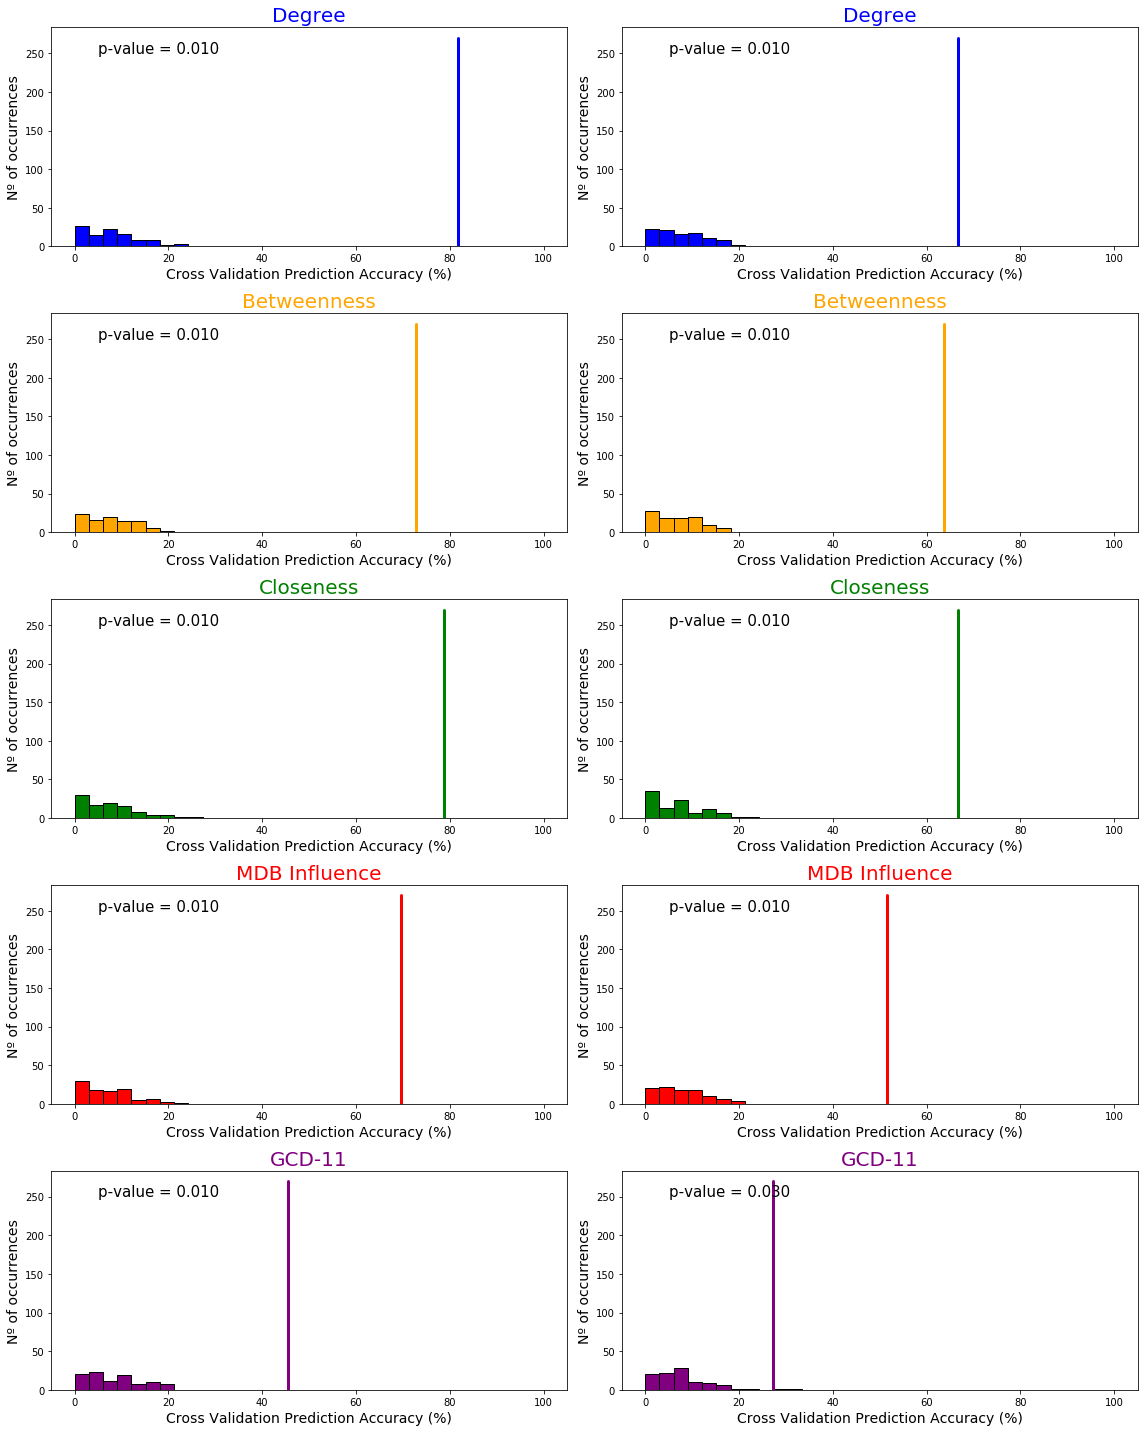

In [158]:
f, axes = plt.subplots(5, 2, figsize = (16,20))

Names = ['Degree', 'Betweenness', 'Closeness', 'Group Inf.', 'GCD-11',
         'pos_Degree', 'pos_Betweenness', 'pos_Closeness', 'pos_Groups', 'pos_GCD-11']
colors = ['blue', 'orange', 'green', 'red', 'purple'] * 2
quadrant = [axes[0][0], axes[1][0], axes[2][0], axes[3][0], axes[4][0],
           axes[0][1], axes[1][1], axes[2][1], axes[3][1], axes[4][1]]
ylim = [0,270]
n_labels = len(degree_neg_TF.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(5,250, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    if name.startswith('pos'):
        name = name.split('_')[-1]
        if name == 'Groups':
            name = 'MDB Influence'
    elif name.endswith('GD'):
        name = name.split(' ')[0]
    elif name == 'Group Inf.':
        name = 'MDB Influence'
    q.set_title(name, size = 20, color = color)

plt.tight_layout()
#plt.savefig('Net-Perm-GD-RF')